In [1]:
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from galerkin import DGMNet
from branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## PDE solver using dolfinx

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
# import tqdm.notebook

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc
from dolfinx.fem.petsc import apply_lifting, assemble_matrix, assemble_vector, create_vector, set_bc
from dolfinx.graph import create_adjacencylist
from dolfinx.geometry import BoundingBoxTree, compute_collisions, compute_colliding_cells
from dolfinx.io import (XDMFFile, cell_perm_gmsh, distribute_entity_data, extract_gmsh_geometry,
                        extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh)
from dolfinx.mesh import create_mesh, meshtags_from_entities

from ufl import (FacetNormal, FiniteElement, Identity, Measure, TestFunction, TrialFunction, VectorElement,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym)

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y =0.2
r = 0.05
gdim = 2
rank = MPI.COMM_WORLD.rank
if rank == 0:
    rectangle = gmsh.model.occ.addRectangle(0,0,0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)
    
if rank == 0:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()
    
fluid_marker = 1
if rank == 0:
    volumes = gmsh.model.getEntities(dim=gdim)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")
    
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if rank == 0:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H/2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H/2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L/2, H, 0]) or np.allclose(center_of_mass, [L/2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax
res_min = r / 3.7
res_max = 1.5 * r
if rank == 0:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", obstacle)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(2, "LcMax", res_max)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4*r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 8*r)

    # We take the minimum of the two fields as the mesh size
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)
    
if rank == 0:
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 8)
    gmsh.option.setNumber("Mesh.RecombineAll", 2)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")
    
if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

    # Sort elements by ascending dimension
    perm_sort = np.argsort(cell_dimensions)

    # Broadcast cell type data and geometric dimension
    cell_id = cell_information[perm_sort[-1]]["id"]
    tdim = cell_information[perm_sort[-1]]["dim"]
    num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)
    if tdim - 1 in cell_dimensions:
        num_facet_nodes = MPI.COMM_WORLD.bcast( cell_information[perm_sort[-2]]["num_nodes"], root=0)
        gmsh_facet_id = cell_information[perm_sort[-2]]["id"]
        marked_facets = np.asarray(topologies[gmsh_facet_id]["topology"], dtype=np.int64)
        facet_values = np.asarray(topologies[gmsh_facet_id]["cell_data"], dtype=np.int32)

    cells = np.asarray(topologies[cell_id]["topology"], dtype=np.int64)
    cell_values = np.asarray(topologies[cell_id]["cell_data"], dtype=np.int32)

else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = np.empty([0, num_nodes], np.int64), np.empty([0, gdim])
    cell_values = np.empty((0,), dtype=np.int32)
    num_facet_nodes = MPI.COMM_WORLD.bcast(None, root=0)
    marked_facets = np.empty((0, num_facet_nodes), dtype=np.int64)
    facet_values = np.empty((0,), dtype=np.int32)

# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = cell_perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim
fdim = tdim - 1
# Permute facets from MSH to DOLFINx ordering
# FIXME: Last argument is 0 as all facets are the same for tetrahedra
facet_type = cell_entity_type(to_type(str(ufl_domain.ufl_cell())), fdim, 0)
gmsh_facet_perm = cell_perm_gmsh(facet_type, num_facet_nodes)
marked_facets = np.asarray(marked_facets[:, gmsh_facet_perm], dtype=np.int64)

local_entities, local_values = distribute_entity_data(mesh, fdim, marked_facets, facet_values)
mesh.topology.create_connectivity(fdim, tdim)
adj = create_adjacencylist(local_entities)
# Create DOLFINx MeshTags
ft = meshtags_from_entities(mesh, fdim, adj, np.int32(local_values))
ft.name = "Facet tags"

t = 0
T = 1 #8                    # Final time
dt = 1/1600                 # Time step size
num_steps = int(T/dt)
k = Constant(mesh, PETSc.ScalarType(dt))        
mu = Constant(mesh, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(mesh, PETSc.ScalarType(1))     # Density

v_cg2 = VectorElement("CG", mesh.ufl_cell(), 2)
s_cg1 = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v_cg2)
Q = FunctionSpace(mesh, s_cg1)

fdim = mesh.topology.dim - 1

# Define boundary conditions
class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi/8) * x[1] * (0.41 - x[1])/(0.41**2)
        return values

# Inlet
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
inlet_facets = ft.indices[ft.values == inlet_marker]

bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(V, fdim, inlet_facets))
# Walls
u_nonslip = np.array((0,) *mesh.geometry.dim, dtype=PETSc.ScalarType)
wall_facets = ft.indices[ft.values == wall_marker]
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, wall_facets), V)
# Obstacle
obstacle_facets = ft.indices[ft.values == obstacle_marker]
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, obstacle_facets), V)
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]
# Outlet
outlet_facets = ft.indices[ft.values == outlet_marker]
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, outlet_facets), Q)
bcp = [bcp_outlet]

u = TrialFunction(V)
v = TestFunction(V)
u_ = Function(V)
u_.name = "u"
u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)
p = TrialFunction(Q)
q = TestFunction(Q)
p_ = Function(Q)
p_.name = "p"
phi = Function(Q)

f = Constant(mesh, PETSc.ScalarType((0,0)))
F1 = rho / k * dot(u - u_n, v) * dx 
F1 += inner(1.5 * dot(u_n, nabla_grad(u_n)) - 0.5 * dot(u_n1, nabla_grad(u_n1)), v) * dx
F1 += 0.5 * mu * inner(grad(u+u_n), grad(v))*dx - dot(p_, div(v))*dx
F1 += dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

a2 = form(dot(grad(p), grad(q))*dx)
L2 = form(-1/k * dot(div(u_s), q) * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

a3 = form(dot(u, v)*dx)
L3 = form(dot(u_s, v)*dx - k * dot(nabla_grad(phi), v)*dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

n = -FacetNormal(mesh) # Normal pointing out of obstacle
dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u_)
drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] - p_ * n[0]) * dObs)
lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] + p_ * n[1]) * dObs)
if rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)
    
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)
    
xdmf = XDMFFile(MPI.COMM_WORLD, "dfg2D-3.xdmf", "w")
xdmf.write_mesh(mesh)
xdmf.write_function(u_, t)
xdmf.write_function(p_, t)

# progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)
# If running this as a python script, you should use the Progressbar command below
# progress = tqdm.tqdm(desc="Solving PDE", total=num_steps)
for i in range(num_steps):
    # progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc:
        loc.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_s.vector)
    u_s.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc:
        loc.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, phi.vector)
    phi.x.scatter_forward()

    p_.vector.axpy(1, phi.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()

    # Write solutions to file
    xdmf.write_function(u_, t)
    xdmf.write_function(p_, t)

    # Update variable with solution form this time step
    with u_.vector.localForm() as loc_, u_n.vector.localForm() as loc_n, u_n1.vector.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in paralell, we gather contributions from all processors
    # to processor zero and sum the contributions. 
    drag_coeff = MPI.COMM_WORLD.gather(assemble_scalar(drag), root=0)
    lift_coeff = MPI.COMM_WORLD.gather(assemble_scalar(lift), root=0)
    p_front = None
    if len(front_cells) > 0:
        p_front = p_.eval(points[0], front_cells[:1])
    p_front = MPI.COMM_WORLD.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_.eval(points[1], back_cells[:1])
    p_back = MPI.COMM_WORLD.gather(p_back, root=0)
    if rank == 0:
        t_u[i] = t
        t_p[i] = t-dt/2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break
# Close xmdf file
xdmf.close()
print("Simulation done!")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Ellipse)
Info    : Done meshing 1D (Wall 0.0078379s, CPU 0.004714s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Simple recombination completed (Wall 0.0182901s, CPU 0.017878s): 1180 quads, 354 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.773076, min Q = 0.435836
Info    : Done meshing 2D (Wall 0.0474852s, CPU 0.045689s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info    : [ 50%] Meshing curve 4 order 2
Info    : [ 70%] Meshing curve 5 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 0.845684 (0 elements in ]0, 0.2]); wo

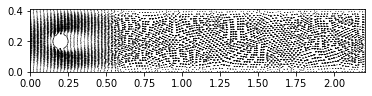

In [2]:
from dolfinx.plot import create_vtk_mesh
from scipy import spatial
import pyvista
cells, types, x = create_vtk_mesh(V)
tree = spatial.KDTree(x[:, :2])

# smaller subset of x
nb_points = 100
x1, x2 = np.meshgrid(
        np.linspace(0, L, nb_points),
        np.linspace(0, H, nb_points)
)
# get the nearest point
val, idx = tree.query(np.stack((x1, x2)).reshape(2, -1).T)

u_tmp = u_.x.array.reshape(x.shape[0], V.dofmap.index_map_bs)
u1, u2 = u_tmp[idx, 0], u_tmp[idx, 1]
x1, x2 = x[idx, 0], x[idx, 1]

plt.xlim(0, L)
plt.ylim(0, H)
plt.axis('scaled')
plt.quiver(x1, x2, u1, u2)
plt.savefig("quiver.png", dpi=300)

# Implementation with closed-form formula given by Borodin

In [2]:
lower_bound, upper_bound = -10, 10

def conditional_probability_to_survive(t, x, y, k_arr=range(-5, 5)):
    ans = 0
    for k in k_arr:
        ans += (
                torch.exp(((y - x) ** 2 - (y - x + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
                - torch.exp(((y - x) ** 2 - (y + x - 2 * lower_bound + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
        )
    return ans.prod(dim=0)

def is_x_inside(x):
    return torch.logical_and(lower_bound <= x, x <= upper_bound).all(dim=0)

## Example 1: heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
\begin{align*}
u_A(t, x) = 
\sum\limits_{k=-\infty}^\infty
& \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
\\
& - \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
\end{align*}
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [7]:
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi, n = 0., lower_bound, upper_bound, 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

patches = 10
T = patches * 1.0
true = exact_example(t_lo, grid_d_dim, T)
true_with_bound = exact_example(t_lo, grid_d_dim, T, with_bound=True)
terminal = exact_example(T, grid_d_dim, T)

Patch 0: generation of samples take 0.47871899604797363 seconds.


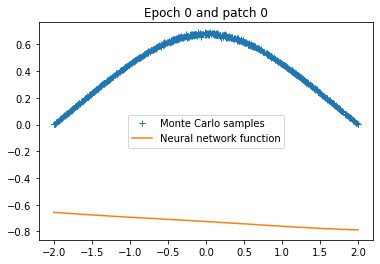

Patch 0: epoch 0 with loss 1.5763740539550781


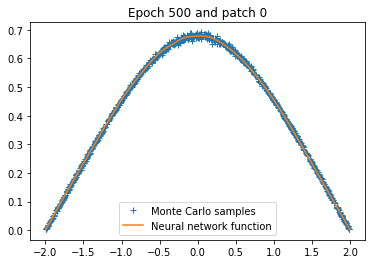

Patch 0: epoch 500 with loss 1.5217096006381325e-05


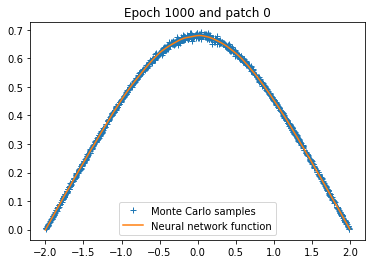

Patch 0: epoch 1000 with loss 1.469581275159726e-05


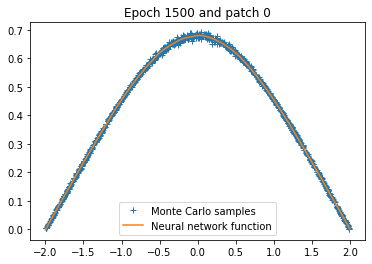

Patch 0: epoch 1500 with loss 1.430162683391245e-05


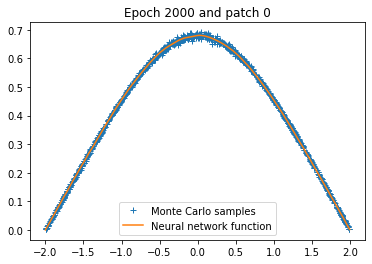

Patch 0: epoch 2000 with loss 1.4574835404346231e-05


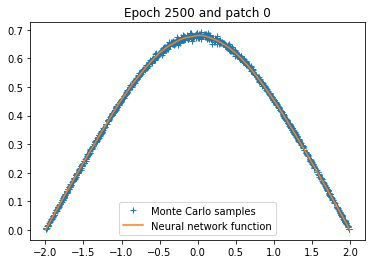

Patch 0: epoch 2500 with loss 1.405858711223118e-05


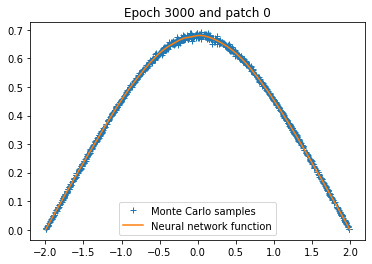

Patch 0: epoch 3000 with loss 1.450162562832702e-05


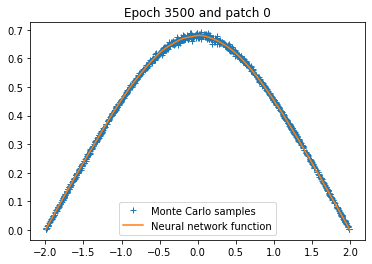

Patch 0: epoch 3500 with loss 1.3941443285148125e-05


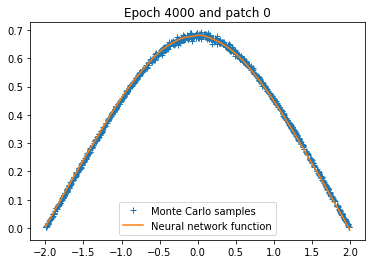

Patch 0: epoch 4000 with loss 1.5793564671184868e-05


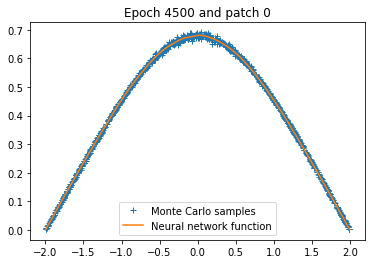

Patch 0: epoch 4500 with loss 1.4472580915025901e-05


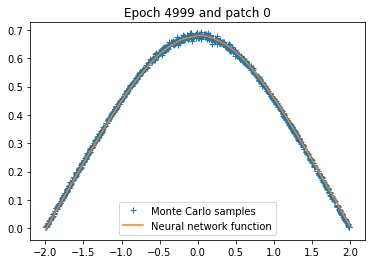

Patch 0: epoch 4999 with loss 2.7699883503373712e-05
Patch 0: training of neural network with 5000 epochs take 20.17610001564026 seconds.
Patch 1: generation of samples take 0.6257991790771484 seconds.


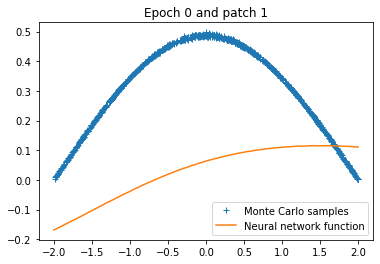

Patch 1: epoch 0 with loss 2.805339813232422


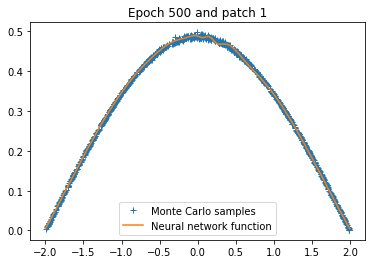

Patch 1: epoch 500 with loss 8.569969395466615e-06


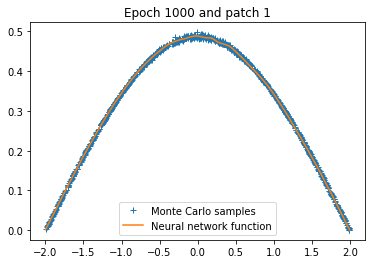

Patch 1: epoch 1000 with loss 4.031930984638166e-06


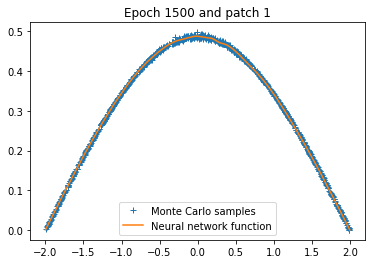

Patch 1: epoch 1500 with loss 3.749522420548601e-06


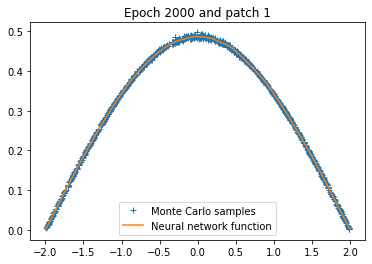

Patch 1: epoch 2000 with loss 3.5723569453693926e-06


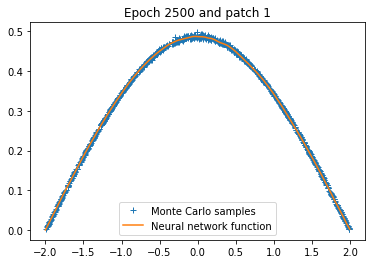

Patch 1: epoch 2500 with loss 3.7448257899086457e-06


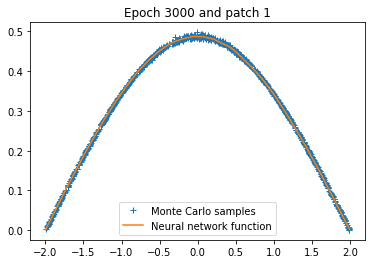

Patch 1: epoch 3000 with loss 3.914713943231618e-06


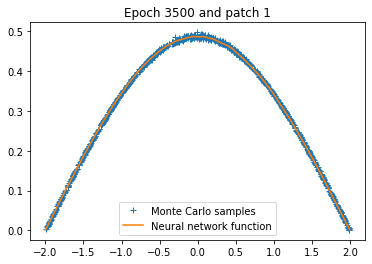

Patch 1: epoch 3500 with loss 3.3746428016456775e-06


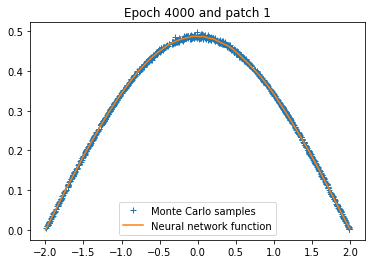

Patch 1: epoch 4000 with loss 4.550270205072593e-06


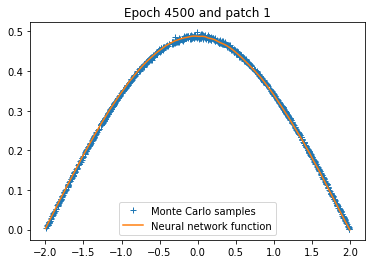

Patch 1: epoch 4500 with loss 3.610810836107703e-06


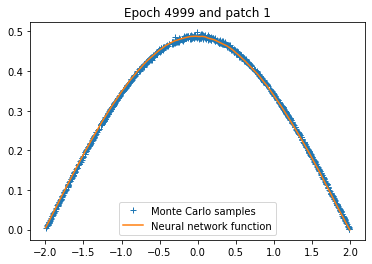

Patch 1: epoch 4999 with loss 1.1672776963678189e-05
Patch 1: training of neural network with 5000 epochs take 20.999719381332397 seconds.
Patch 2: generation of samples take 0.62674880027771 seconds.


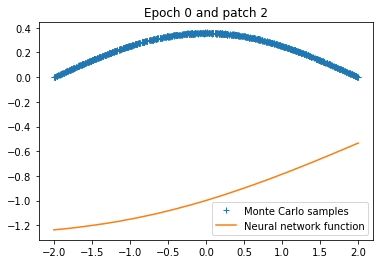

Patch 2: epoch 0 with loss 7.740444183349609


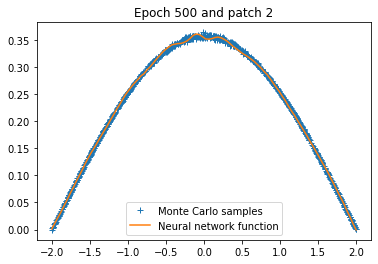

Patch 2: epoch 500 with loss 5.972855433356017e-06


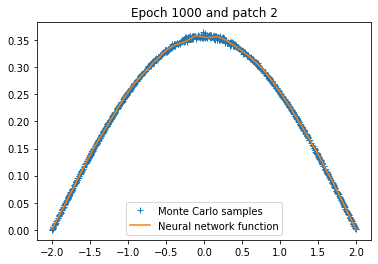

Patch 2: epoch 1000 with loss 1.3464229596138466e-05


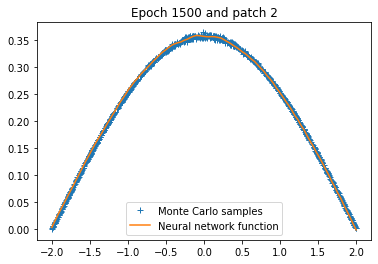

Patch 2: epoch 1500 with loss 3.848710548481904e-06


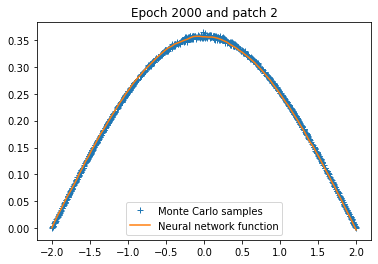

Patch 2: epoch 2000 with loss 1.869023617473431e-05


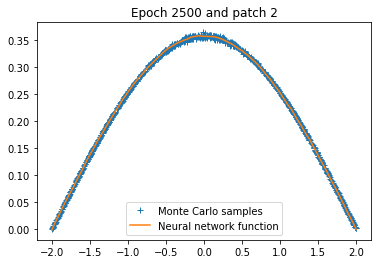

Patch 2: epoch 2500 with loss 2.454423338349443e-06


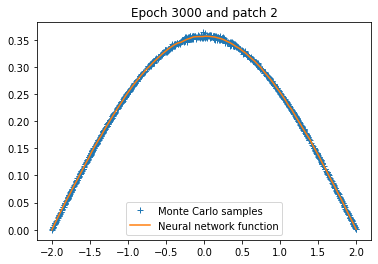

Patch 2: epoch 3000 with loss 2.1751482108811615e-06


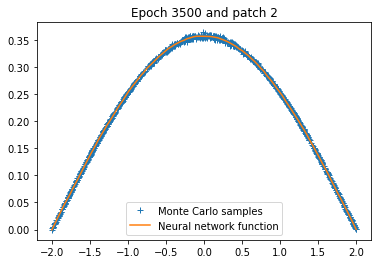

Patch 2: epoch 3500 with loss 4.108301709493389e-06


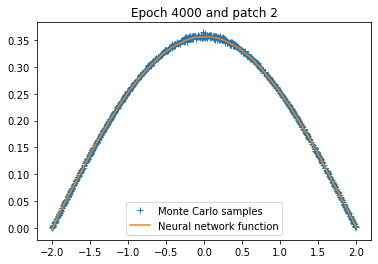

Patch 2: epoch 4000 with loss 2.280037506352528e-06


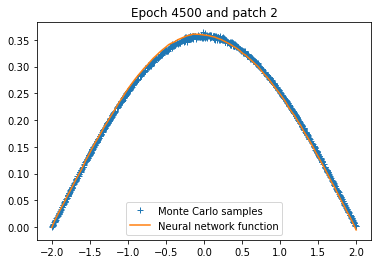

Patch 2: epoch 4500 with loss 1.7582078726263717e-05


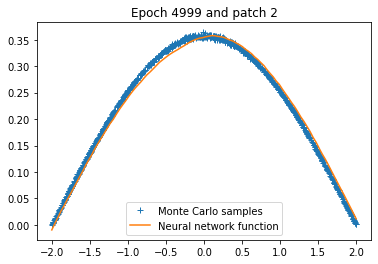

Patch 2: epoch 4999 with loss 0.0001870879641501233
Patch 2: training of neural network with 5000 epochs take 20.48565125465393 seconds.
Patch 3: generation of samples take 0.6271002292633057 seconds.


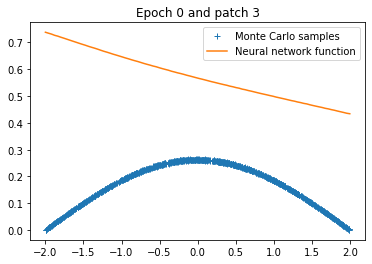

Patch 3: epoch 0 with loss 1.3395674228668213


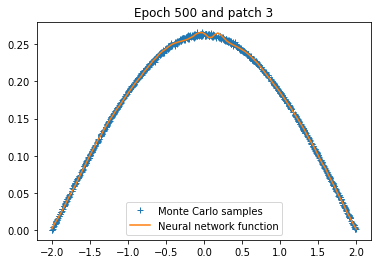

Patch 3: epoch 500 with loss 2.310893933099578e-06


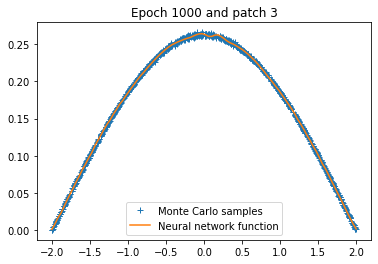

Patch 3: epoch 1000 with loss 1.228140945386258e-06


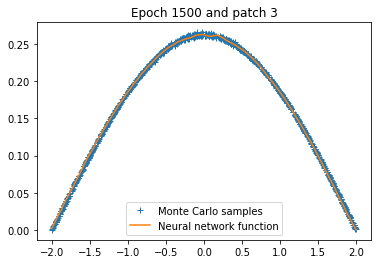

Patch 3: epoch 1500 with loss 1.4318610510599683e-06


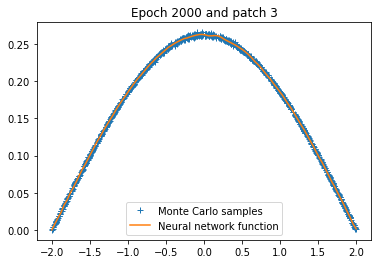

Patch 3: epoch 2000 with loss 1.1854750709971995e-06


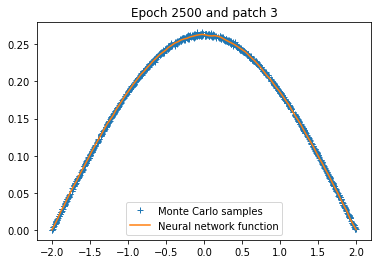

Patch 3: epoch 2500 with loss 8.489308243042615e-07


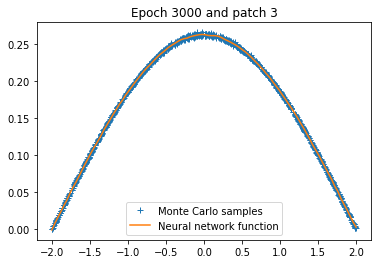

Patch 3: epoch 3000 with loss 8.351278211193858e-07


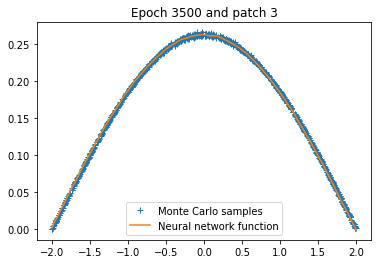

Patch 3: epoch 3500 with loss 1.2112067224734346e-06


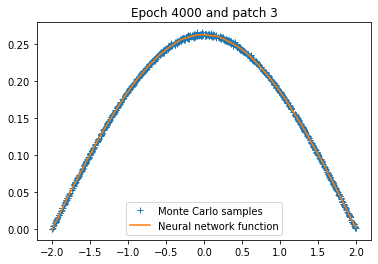

Patch 3: epoch 4000 with loss 8.953663268584933e-07


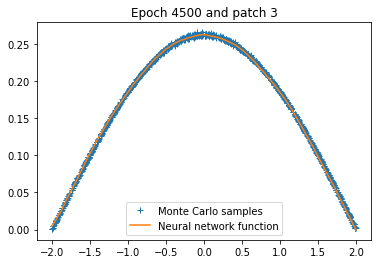

Patch 3: epoch 4500 with loss 1.4674966450911597e-06


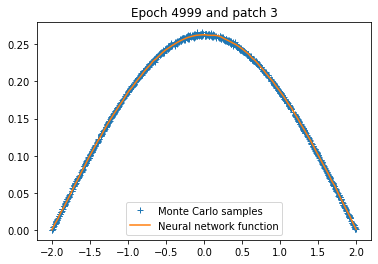

Patch 3: epoch 4999 with loss 8.692446158420353e-07
Patch 3: training of neural network with 5000 epochs take 20.19703960418701 seconds.
Patch 4: generation of samples take 0.6017003059387207 seconds.


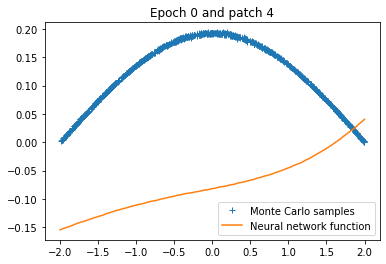

Patch 4: epoch 0 with loss 1.110891342163086


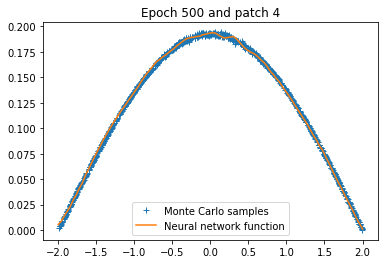

Patch 4: epoch 500 with loss 1.6917691709750216e-06


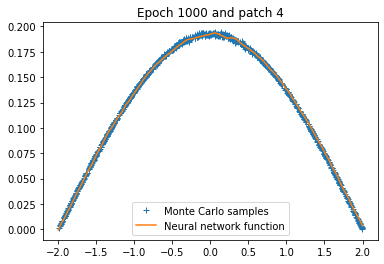

Patch 4: epoch 1000 with loss 2.2868882751936326e-06


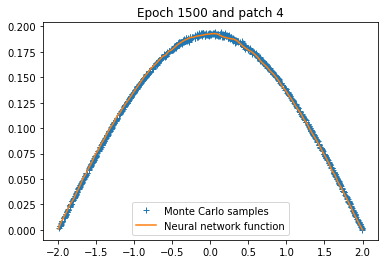

Patch 4: epoch 1500 with loss 1.1831364190584281e-06


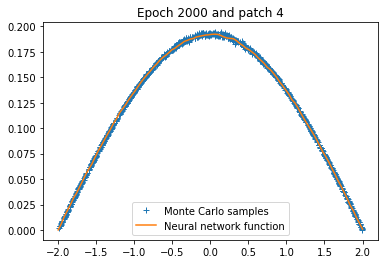

Patch 4: epoch 2000 with loss 9.328975920652738e-07


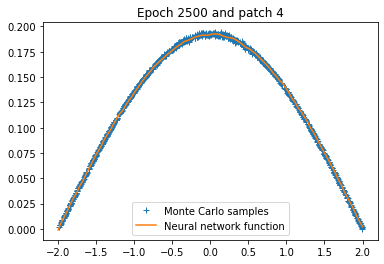

Patch 4: epoch 2500 with loss 5.939145921729505e-07


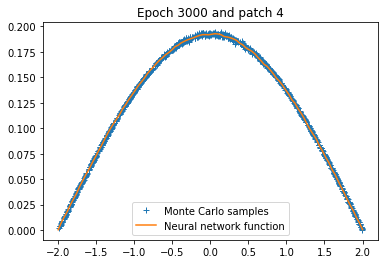

Patch 4: epoch 3000 with loss 5.96686504650279e-07


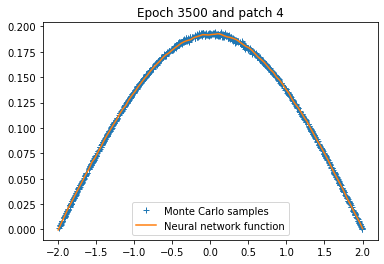

Patch 4: epoch 3500 with loss 5.792968750029104e-06


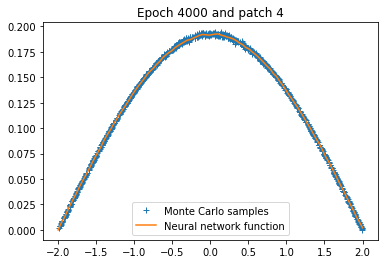

Patch 4: epoch 4000 with loss 6.108613206379232e-07


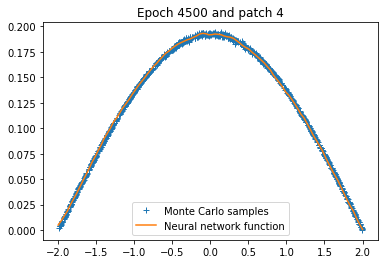

Patch 4: epoch 4500 with loss 8.186929107978358e-07


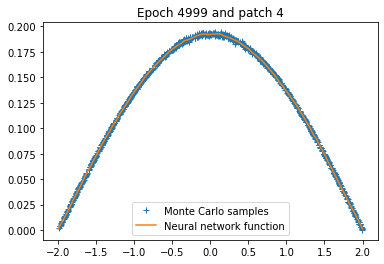

Patch 4: epoch 4999 with loss 6.10314998539252e-07
Patch 4: training of neural network with 5000 epochs take 20.42019557952881 seconds.
Patch 5: generation of samples take 0.6288039684295654 seconds.


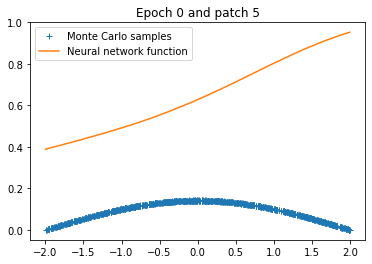

Patch 5: epoch 0 with loss 5.7751359939575195


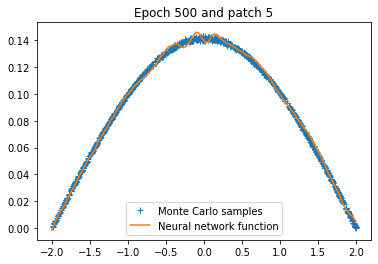

Patch 5: epoch 500 with loss 4.197123871563235e-06


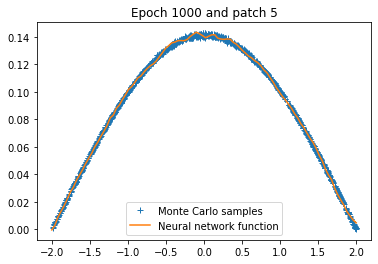

Patch 5: epoch 1000 with loss 2.8554070468089776e-06


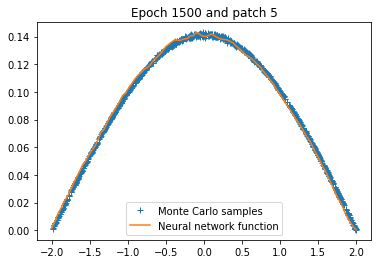

Patch 5: epoch 1500 with loss 2.3688210148975486e-06


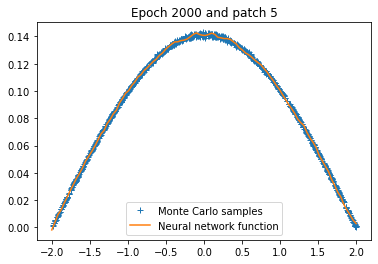

Patch 5: epoch 2000 with loss 2.6345944661443355e-06


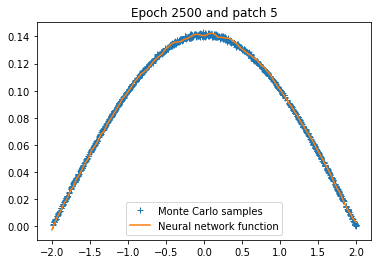

Patch 5: epoch 2500 with loss 7.35210278435261e-07


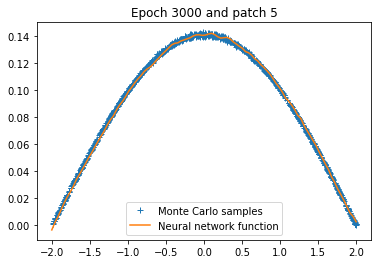

Patch 5: epoch 3000 with loss 6.374770237016492e-06


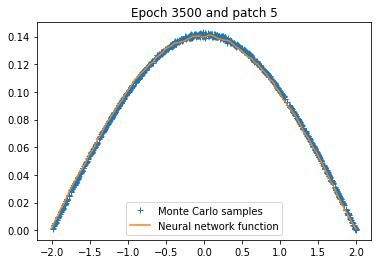

Patch 5: epoch 3500 with loss 2.0400502762640826e-05


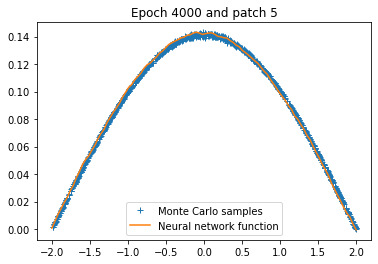

Patch 5: epoch 4000 with loss 1.0420808393973857e-06


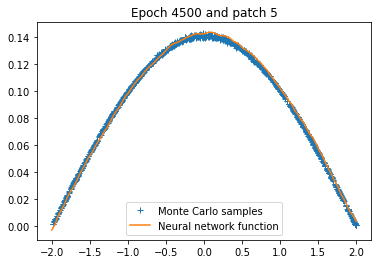

Patch 5: epoch 4500 with loss 2.2841259124106728e-05


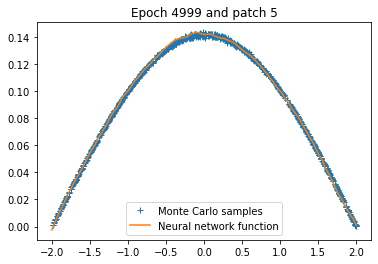

Patch 5: epoch 4999 with loss 1.7826237126428168e-06
Patch 5: training of neural network with 5000 epochs take 20.767984628677368 seconds.
Patch 6: generation of samples take 0.6277346611022949 seconds.


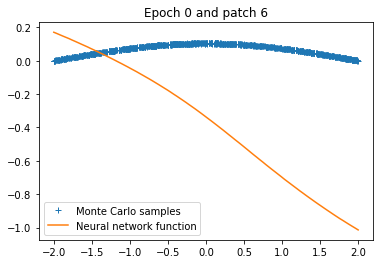

Patch 6: epoch 0 with loss 0.7465671300888062


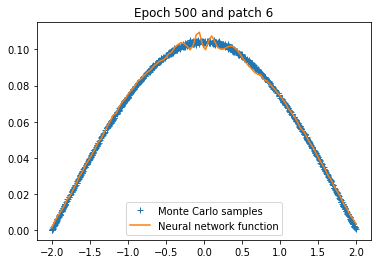

Patch 6: epoch 500 with loss 1.768502215782064e-06


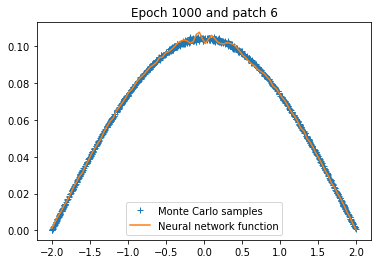

Patch 6: epoch 1000 with loss 9.365544428874273e-07


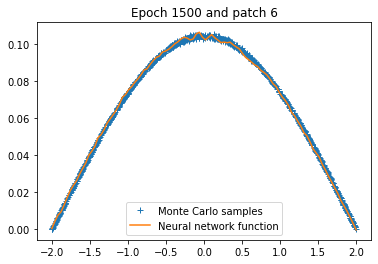

Patch 6: epoch 1500 with loss 5.124948643242533e-07


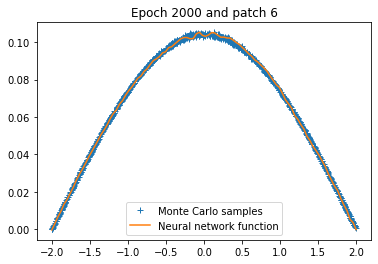

Patch 6: epoch 2000 with loss 4.130379693378927e-06


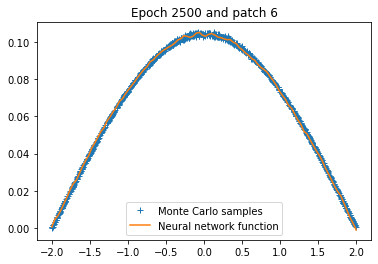

Patch 6: epoch 2500 with loss 6.742093319189735e-07


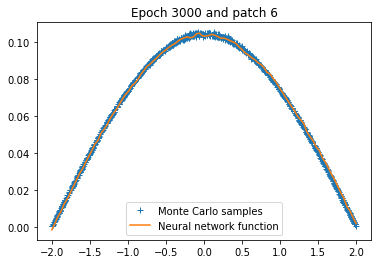

Patch 6: epoch 3000 with loss 4.3983195041619183e-07


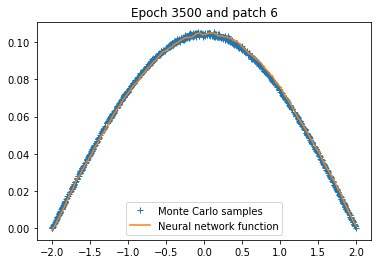

Patch 6: epoch 3500 with loss 1.2451420161596616e-06


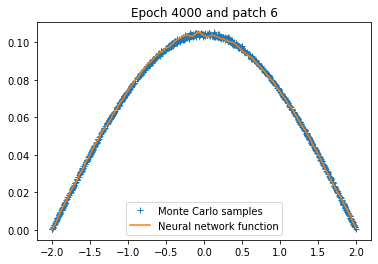

Patch 6: epoch 4000 with loss 4.290700985620788e-07


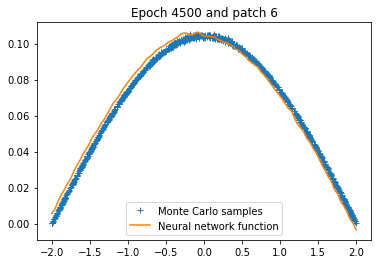

Patch 6: epoch 4500 with loss 2.2442536646849476e-06


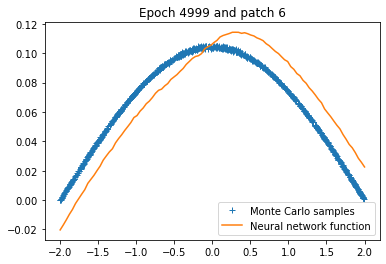

Patch 6: epoch 4999 with loss 0.00017267357907257974
Patch 6: training of neural network with 5000 epochs take 20.466192722320557 seconds.
Patch 7: generation of samples take 0.6272323131561279 seconds.


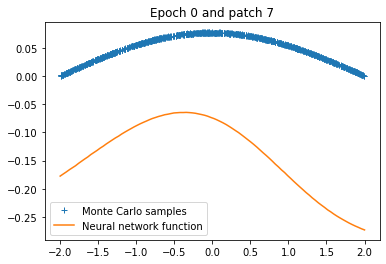

Patch 7: epoch 0 with loss 2.2115895748138428


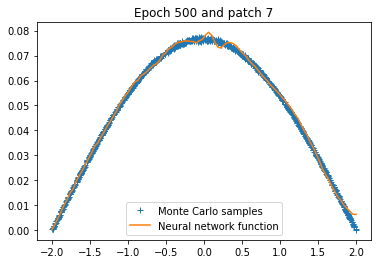

Patch 7: epoch 500 with loss 1.1458938615760417e-06


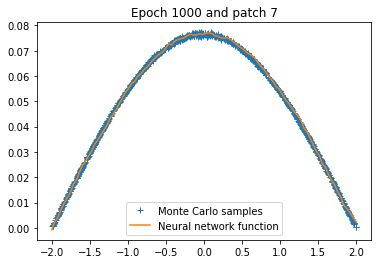

Patch 7: epoch 1000 with loss 1.9608185084507568e-06


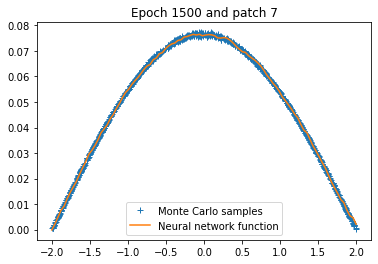

Patch 7: epoch 1500 with loss 2.3132569992867502e-07


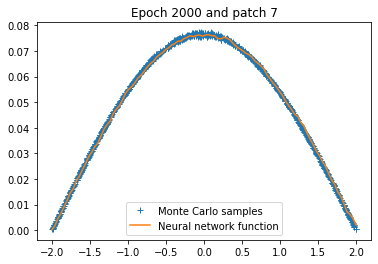

Patch 7: epoch 2000 with loss 1.263446279153868e-06


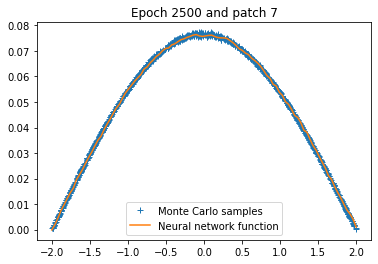

Patch 7: epoch 2500 with loss 3.976251718995627e-07


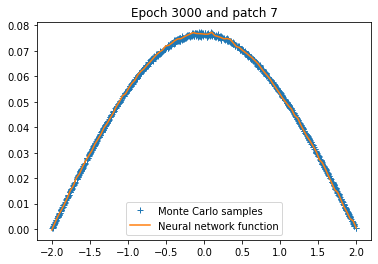

Patch 7: epoch 3000 with loss 4.925923349219374e-07


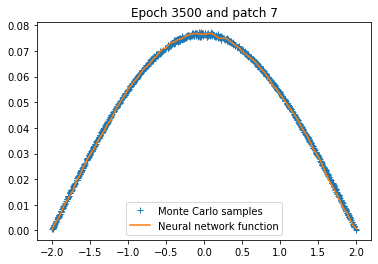

Patch 7: epoch 3500 with loss 6.12344649653096e-07


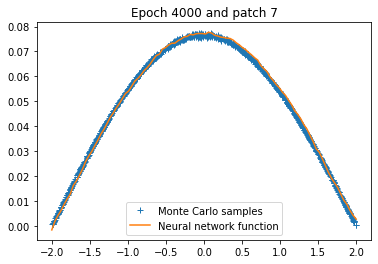

Patch 7: epoch 4000 with loss 1.9361123122507706e-06


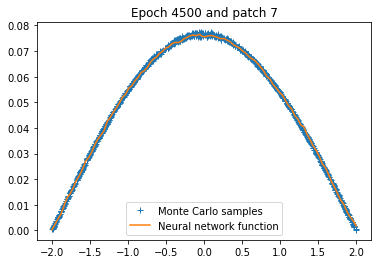

Patch 7: epoch 4500 with loss 2.7452571771391376e-07


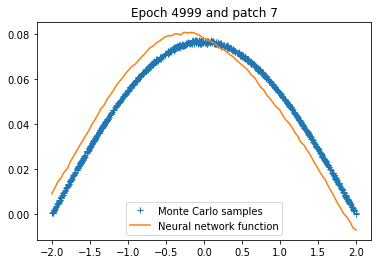

Patch 7: epoch 4999 with loss 2.6005662220995873e-05
Patch 7: training of neural network with 5000 epochs take 20.593668699264526 seconds.
Patch 8: generation of samples take 0.6599903106689453 seconds.


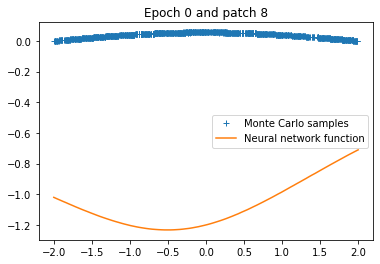

Patch 8: epoch 0 with loss 0.3379201889038086


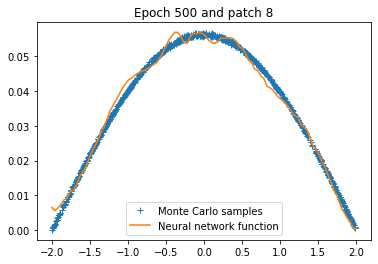

Patch 8: epoch 500 with loss 4.905380592390429e-06


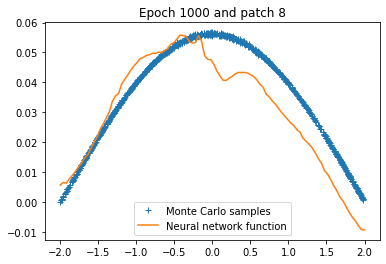

Patch 8: epoch 1000 with loss 8.026273462746758e-06


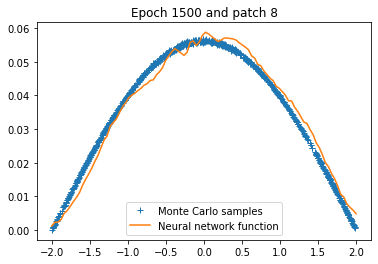

Patch 8: epoch 1500 with loss 1.6590811355854385e-06


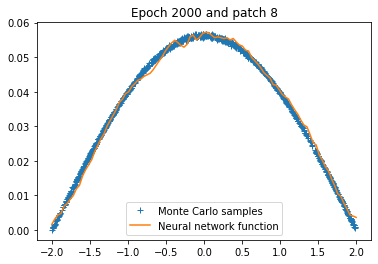

Patch 8: epoch 2000 with loss 5.808313289890066e-06


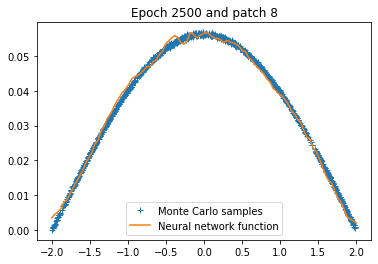

Patch 8: epoch 2500 with loss 3.6805074614676414e-06


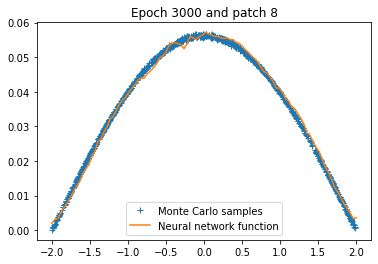

Patch 8: epoch 3000 with loss 1.3159007039575954e-06


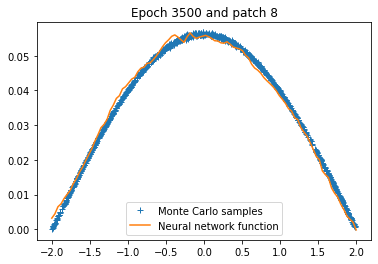

Patch 8: epoch 3500 with loss 2.7496939765114803e-06


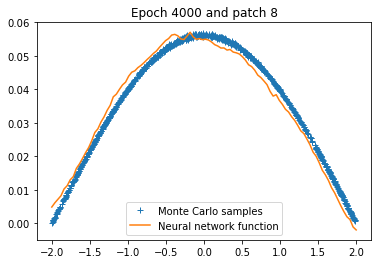

Patch 8: epoch 4000 with loss 9.00187387742335e-06


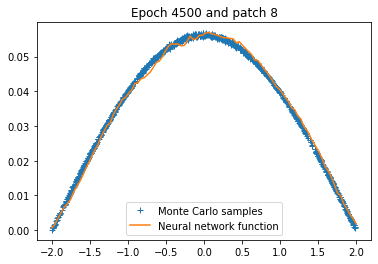

Patch 8: epoch 4500 with loss 8.901712931219663e-07


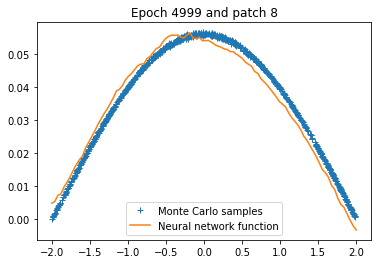

Patch 8: epoch 4999 with loss 1.5619583791703917e-05
Patch 8: training of neural network with 5000 epochs take 21.196319580078125 seconds.
Patch 9: generation of samples take 0.6529092788696289 seconds.


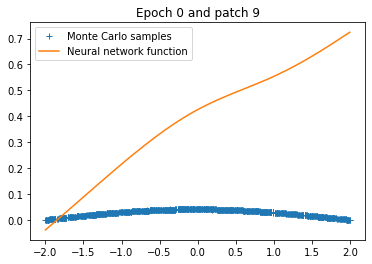

Patch 9: epoch 0 with loss 10.969351768493652


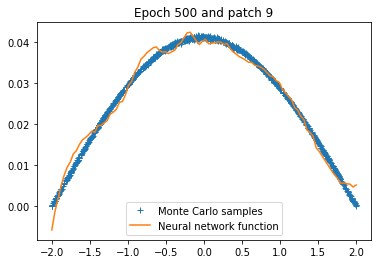

Patch 9: epoch 500 with loss 2.5644601464591688e-06


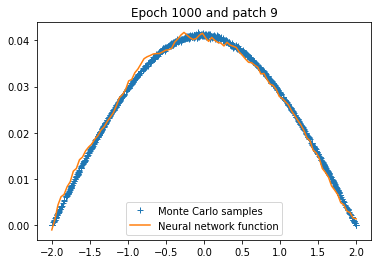

Patch 9: epoch 1000 with loss 1.1366076932972646e-06


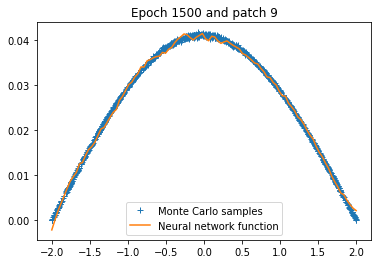

Patch 9: epoch 1500 with loss 3.112023136964126e-07


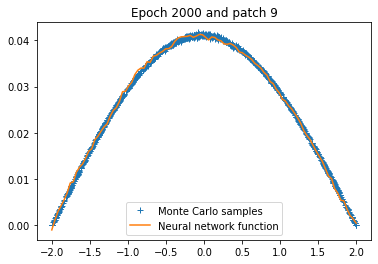

Patch 9: epoch 2000 with loss 1.9827827202334447e-07


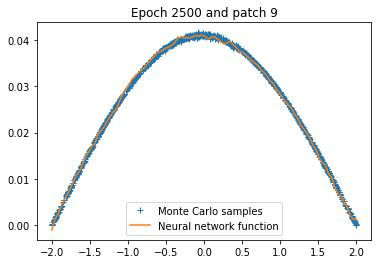

Patch 9: epoch 2500 with loss 1.5194264335605112e-07


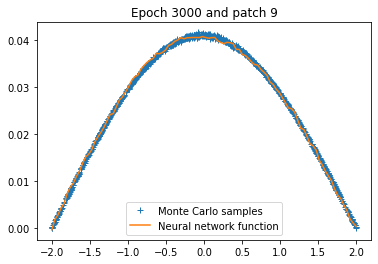

Patch 9: epoch 3000 with loss 1.3196617487665208e-07


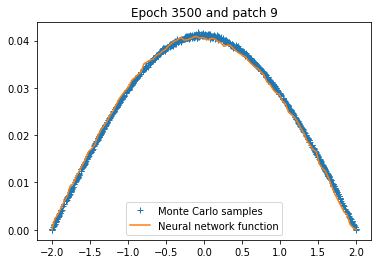

Patch 9: epoch 3500 with loss 1.5010915888069576e-07


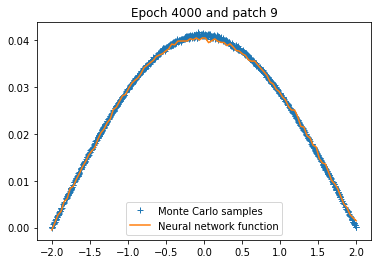

Patch 9: epoch 4000 with loss 3.389830283140327e-07


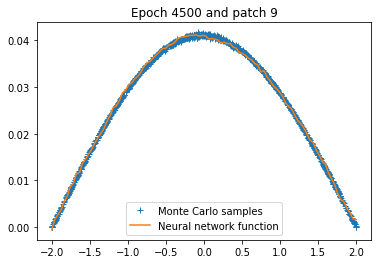

Patch 9: epoch 4500 with loss 2.058510233382549e-07


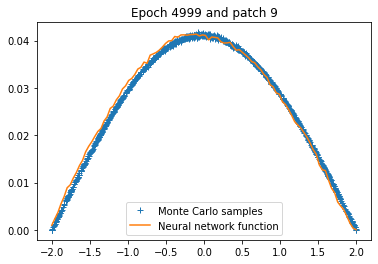

Patch 9: epoch 4999 with loss 7.07740923644451e-07
Patch 9: training of neural network with 5000 epochs take 21.152942657470703 seconds.


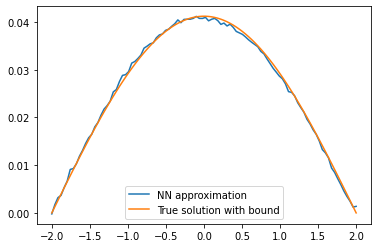

In [8]:
torch.manual_seed(0)

# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
# plt.plot(grid, true, label="True solution without bound")
plt.plot(grid, true_with_bound, label="True solution with bound")
plt.legend()
plt.show()

## Example 2: Kuramoto equation 1

### patches = 10, T = 1.0

In [33]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        15
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 10
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

Patch 0: generation of samples take 61.766056060791016 seconds.


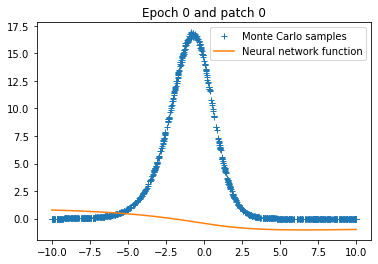

Patch 0: epoch 0 with loss 35.377593994140625


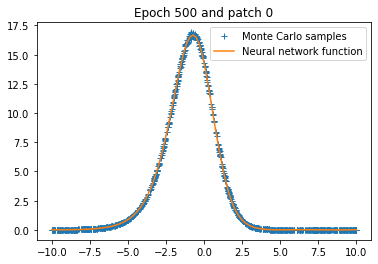

Patch 0: epoch 500 with loss 0.0021850692573934793


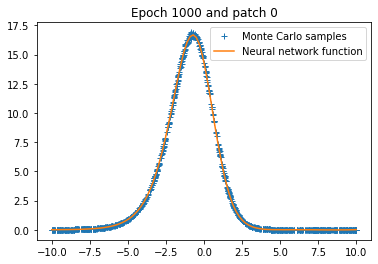

Patch 0: epoch 1000 with loss 0.002406088402494788


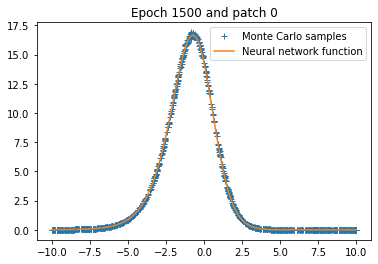

Patch 0: epoch 1500 with loss 0.0021602297201752663


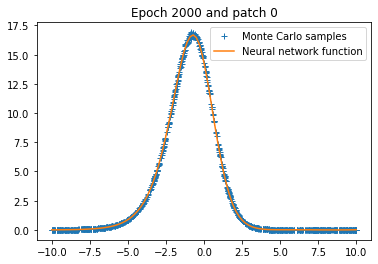

Patch 0: epoch 2000 with loss 0.0021495062392205


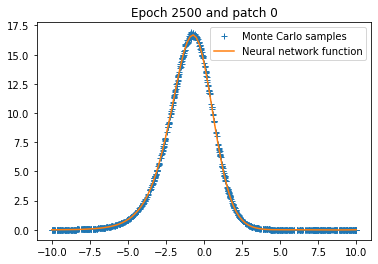

Patch 0: epoch 2500 with loss 0.0021483255550265312


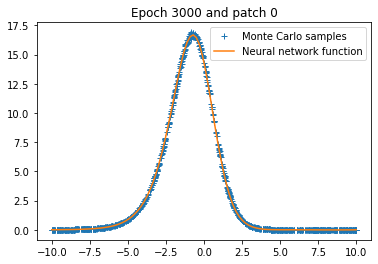

Patch 0: epoch 3000 with loss 0.0021413241047412157


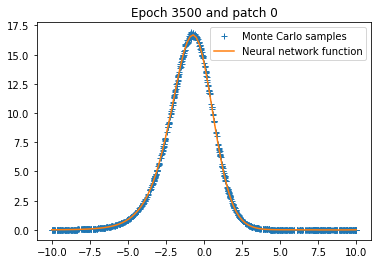

Patch 0: epoch 3500 with loss 0.0021393110509961843


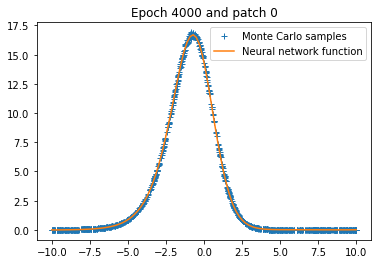

Patch 0: epoch 4000 with loss 0.002147423103451729


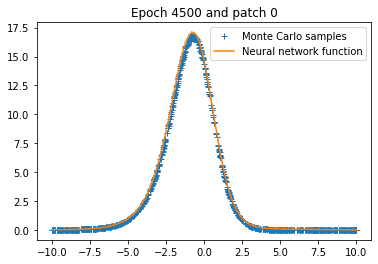

Patch 0: epoch 4500 with loss 0.00468347268179059


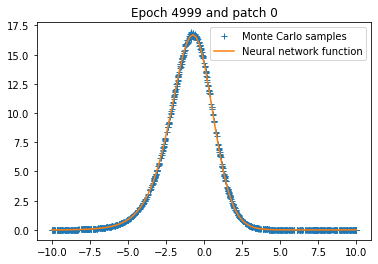

Patch 0: epoch 4999 with loss 0.0021381082478910685
Patch 0: training of neural network with 5000 epochs take 20.61129927635193 seconds.
Patch 1: generation of samples take 171.27772641181946 seconds.


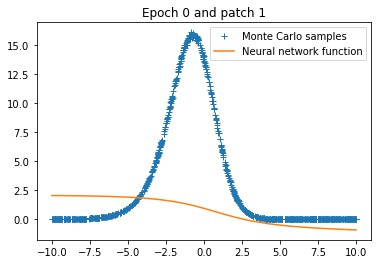

Patch 1: epoch 0 with loss 33.527099609375


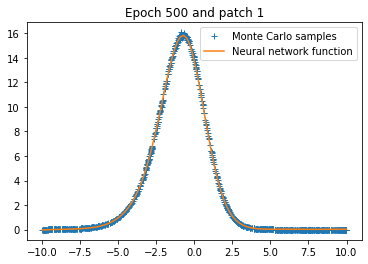

Patch 1: epoch 500 with loss 0.0021401410922408104


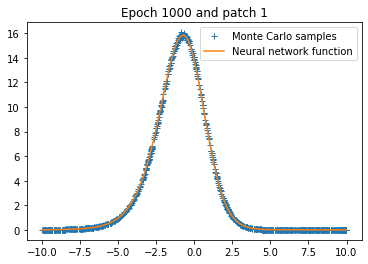

Patch 1: epoch 1000 with loss 0.002075890311971307


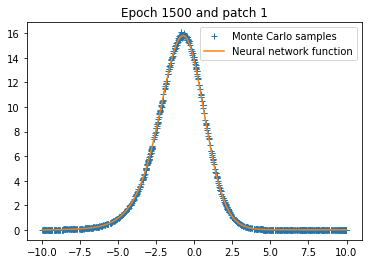

Patch 1: epoch 1500 with loss 0.0019487562822178006


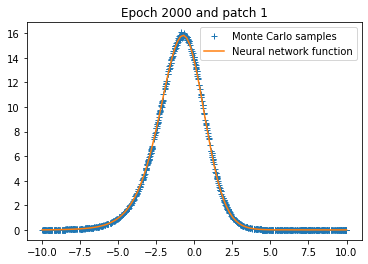

Patch 1: epoch 2000 with loss 0.001948879798874259


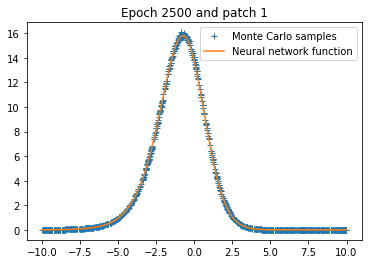

Patch 1: epoch 2500 with loss 0.001923498697578907


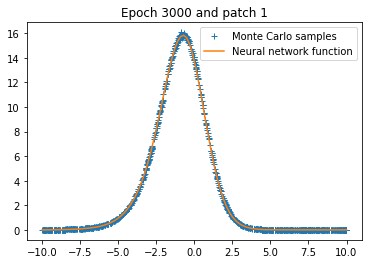

Patch 1: epoch 3000 with loss 0.001920658047311008


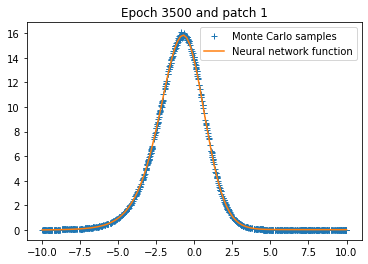

Patch 1: epoch 3500 with loss 0.0019623066764324903


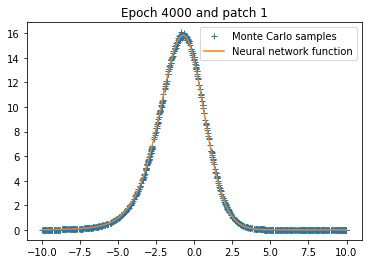

Patch 1: epoch 4000 with loss 0.002067830879241228


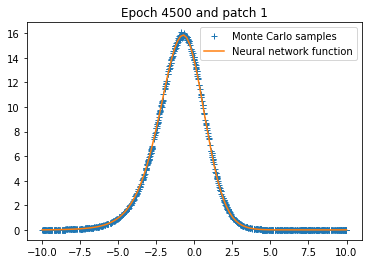

Patch 1: epoch 4500 with loss 0.0020507085137069225


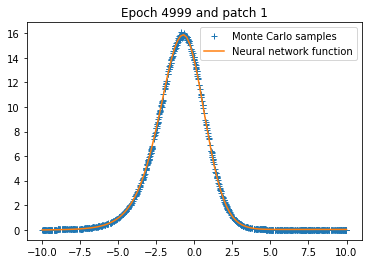

Patch 1: epoch 4999 with loss 0.0024916036054491997
Patch 1: training of neural network with 5000 epochs take 21.083635330200195 seconds.
Patch 2: generation of samples take 170.1739103794098 seconds.


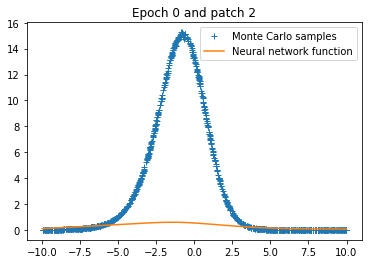

Patch 2: epoch 0 with loss 29.92007064819336


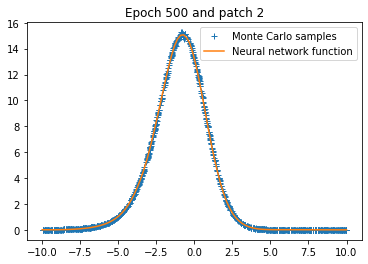

Patch 2: epoch 500 with loss 0.001917372108437121


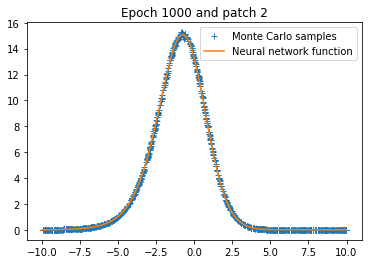

Patch 2: epoch 1000 with loss 0.0019608328584581614


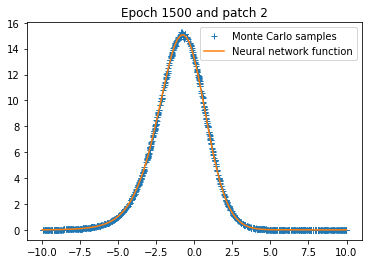

Patch 2: epoch 1500 with loss 0.0018821300473064184


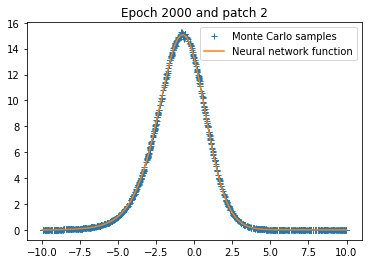

Patch 2: epoch 2000 with loss 0.001874916022643447


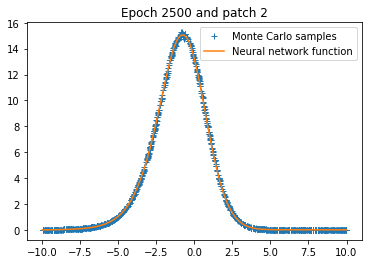

Patch 2: epoch 2500 with loss 0.0018755159107968211


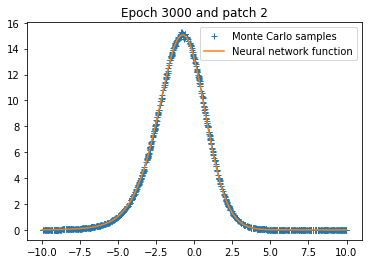

Patch 2: epoch 3000 with loss 0.0018868830520659685


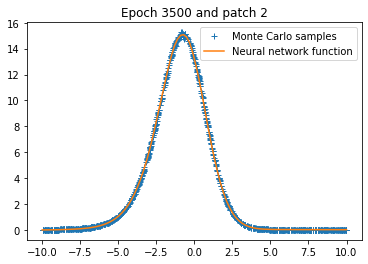

Patch 2: epoch 3500 with loss 0.0019453112035989761


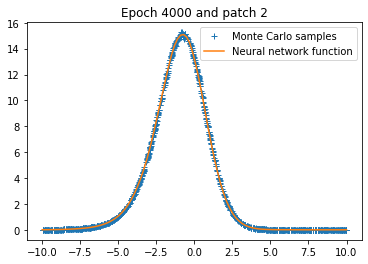

Patch 2: epoch 4000 with loss 0.0018955385312438011


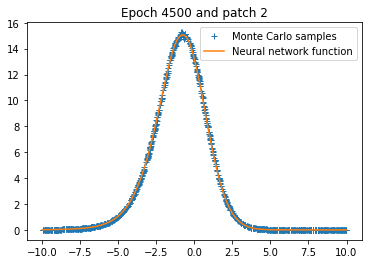

Patch 2: epoch 4500 with loss 0.0019284420413896441


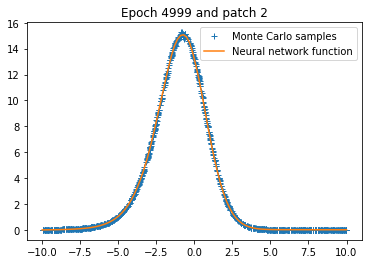

Patch 2: epoch 4999 with loss 0.0018680954817682505
Patch 2: training of neural network with 5000 epochs take 21.21459150314331 seconds.
Patch 3: generation of samples take 179.69944190979004 seconds.


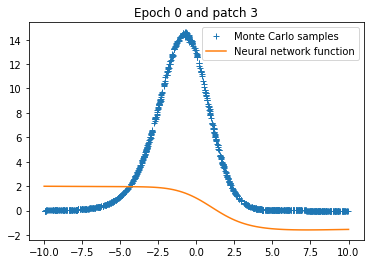

Patch 3: epoch 0 with loss 46.14775848388672


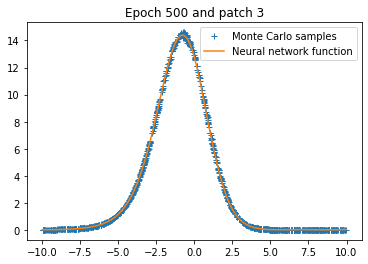

Patch 3: epoch 500 with loss 0.0020089074969291687


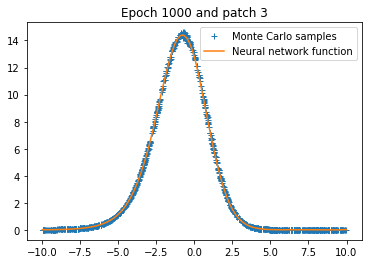

Patch 3: epoch 1000 with loss 0.002007600851356983


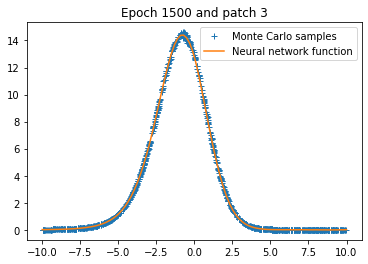

Patch 3: epoch 1500 with loss 0.0019461739575490355


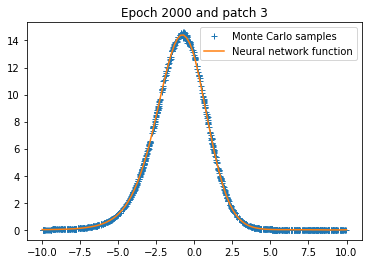

Patch 3: epoch 2000 with loss 0.0020024131517857313


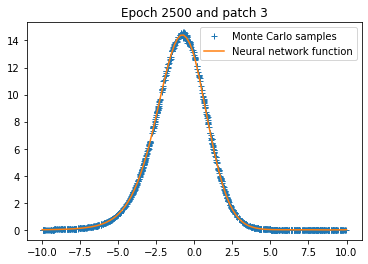

Patch 3: epoch 2500 with loss 0.0019339945865795016


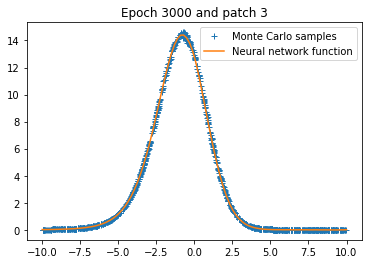

Patch 3: epoch 3000 with loss 0.0019375275587663054


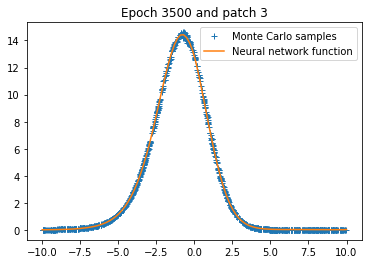

Patch 3: epoch 3500 with loss 0.0019573140889406204


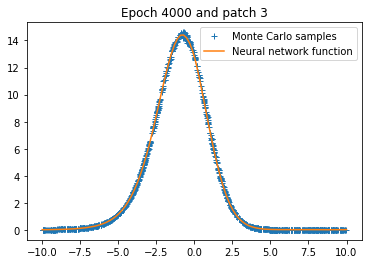

Patch 3: epoch 4000 with loss 0.001976782688871026


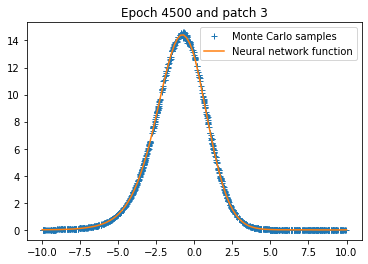

Patch 3: epoch 4500 with loss 0.0019430259708315134


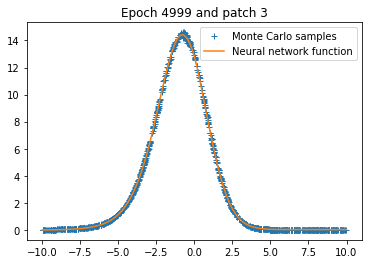

Patch 3: epoch 4999 with loss 0.002095625037327409
Patch 3: training of neural network with 5000 epochs take 20.956831693649292 seconds.
Patch 4: generation of samples take 183.1245231628418 seconds.


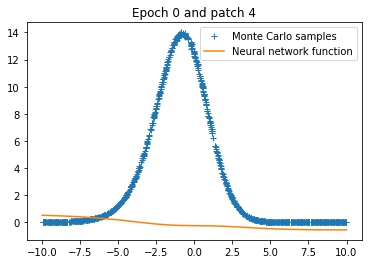

Patch 4: epoch 0 with loss 30.31430435180664


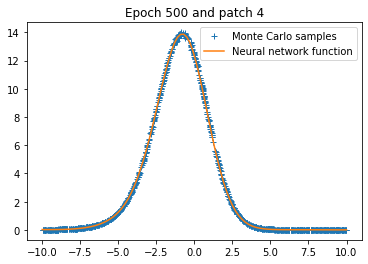

Patch 4: epoch 500 with loss 0.0015575697179883718


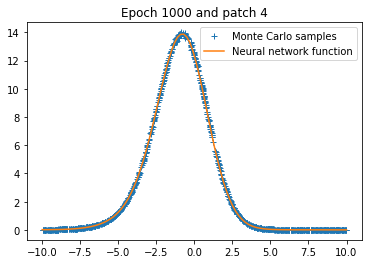

Patch 4: epoch 1000 with loss 0.0015352319460362196


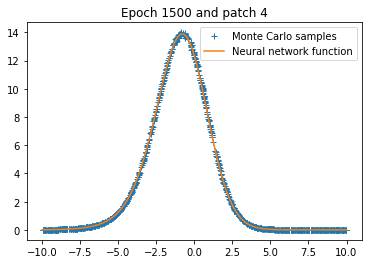

Patch 4: epoch 1500 with loss 0.0015135190915316343


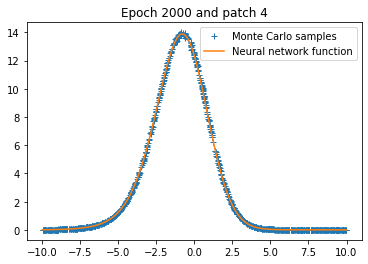

Patch 4: epoch 2000 with loss 0.001508343848399818


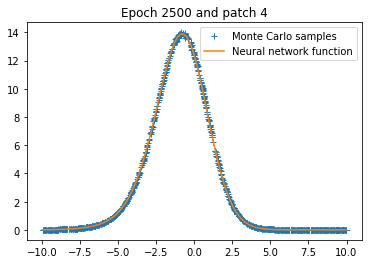

Patch 4: epoch 2500 with loss 0.001503509352914989


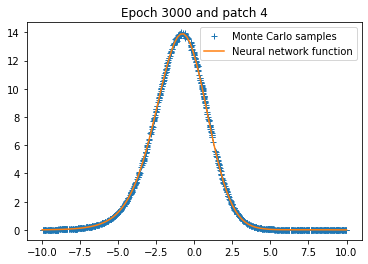

Patch 4: epoch 3000 with loss 0.0015746901044622064


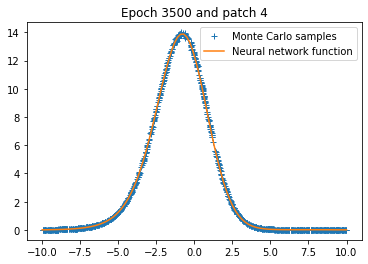

Patch 4: epoch 3500 with loss 0.0015118442242965102


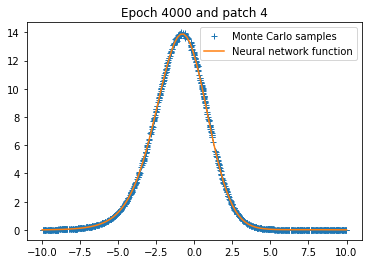

Patch 4: epoch 4000 with loss 0.0015029885107651353


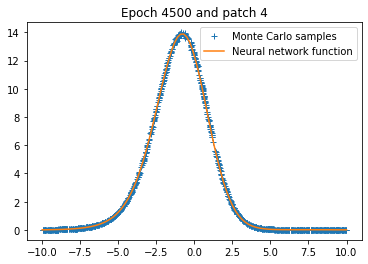

Patch 4: epoch 4500 with loss 0.0015102890320122242


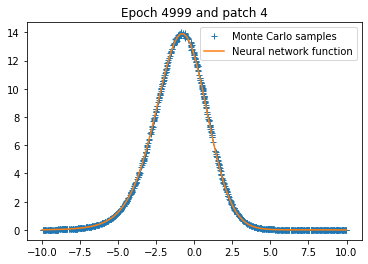

Patch 4: epoch 4999 with loss 0.0015262776287272573
Patch 4: training of neural network with 5000 epochs take 20.66187620162964 seconds.
Patch 5: generation of samples take 181.78751730918884 seconds.


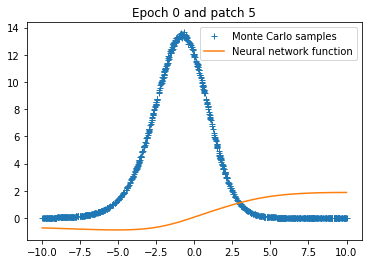

Patch 5: epoch 0 with loss 33.36328887939453


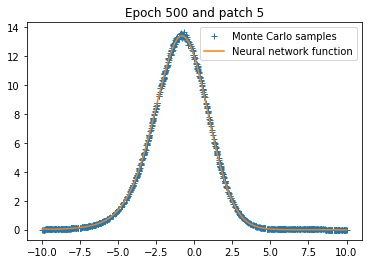

Patch 5: epoch 500 with loss 0.001819680561311543


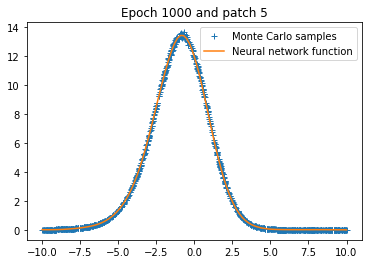

Patch 5: epoch 1000 with loss 0.0022802052553743124


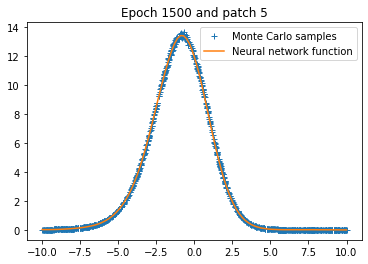

Patch 5: epoch 1500 with loss 0.0017676589777693152


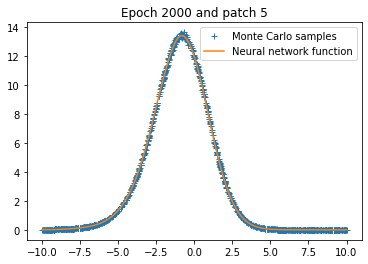

Patch 5: epoch 2000 with loss 0.0017578394617885351


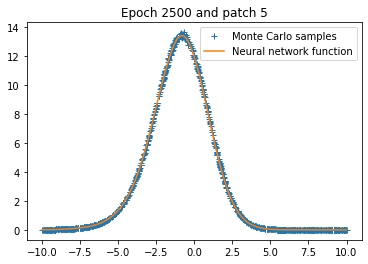

Patch 5: epoch 2500 with loss 0.001763589447364211


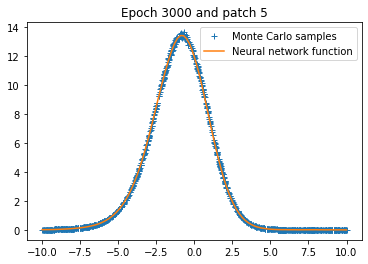

Patch 5: epoch 3000 with loss 0.0017680326709523797


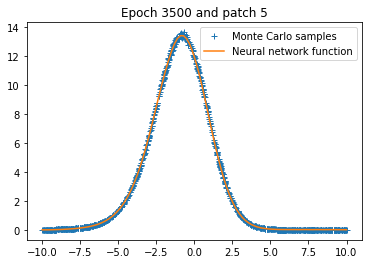

Patch 5: epoch 3500 with loss 0.001769459806382656


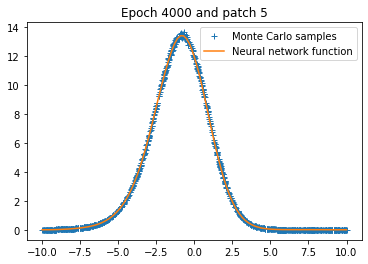

Patch 5: epoch 4000 with loss 0.0017788566183298826


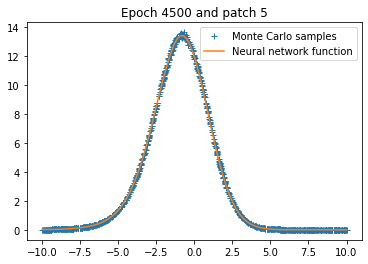

Patch 5: epoch 4500 with loss 0.0017640867736190557


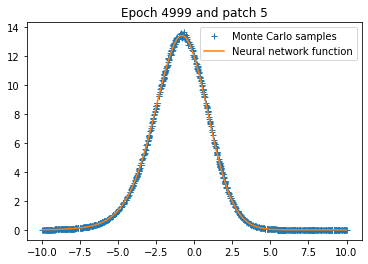

Patch 5: epoch 4999 with loss 0.0017592798685654998
Patch 5: training of neural network with 5000 epochs take 20.359845399856567 seconds.
Patch 6: generation of samples take 176.61168694496155 seconds.


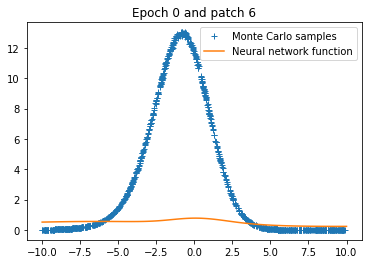

Patch 6: epoch 0 with loss 31.09416961669922


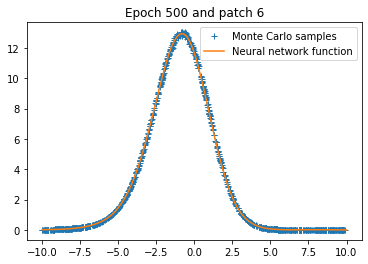

Patch 6: epoch 500 with loss 0.0015623868675902486


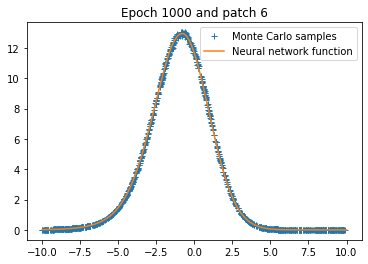

Patch 6: epoch 1000 with loss 0.0015620383201166987


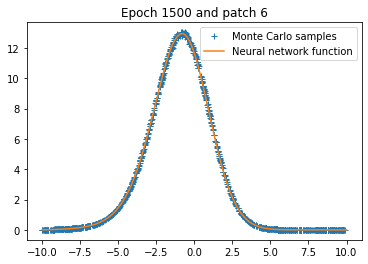

Patch 6: epoch 1500 with loss 0.0015319602098315954


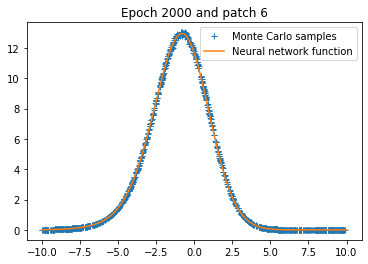

Patch 6: epoch 2000 with loss 0.0015349407913163304


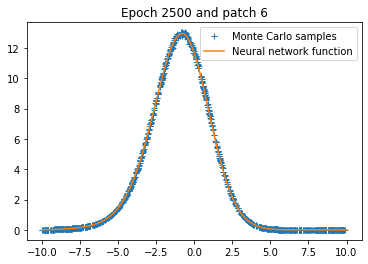

Patch 6: epoch 2500 with loss 0.0015235571190714836


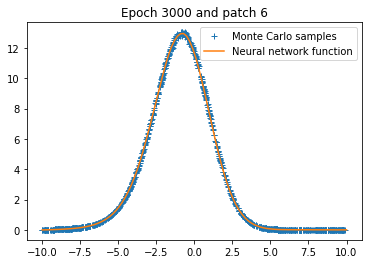

Patch 6: epoch 3000 with loss 0.0015259800711646676


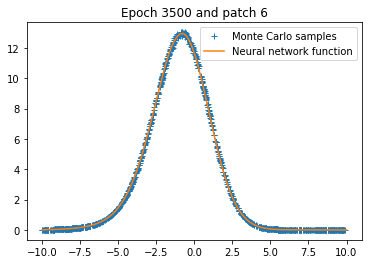

Patch 6: epoch 3500 with loss 0.0015210822457447648


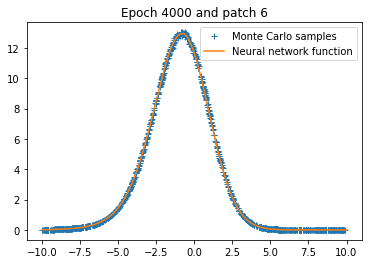

Patch 6: epoch 4000 with loss 0.001530935405753553


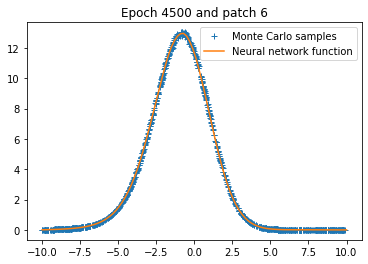

Patch 6: epoch 4500 with loss 0.0015295472694560885


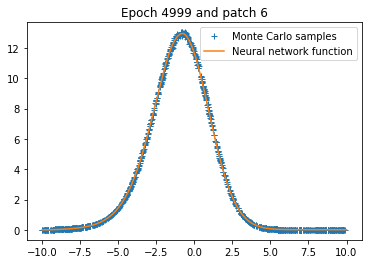

Patch 6: epoch 4999 with loss 0.001588814309798181
Patch 6: training of neural network with 5000 epochs take 20.619675159454346 seconds.
Patch 7: generation of samples take 169.81940007209778 seconds.


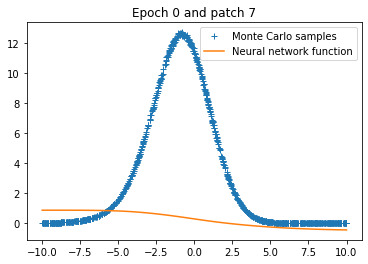

Patch 7: epoch 0 with loss 27.000080108642578


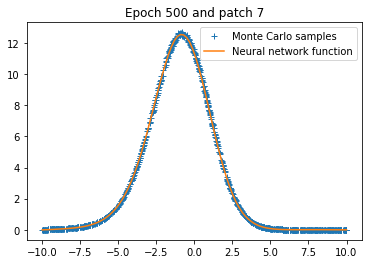

Patch 7: epoch 500 with loss 0.0013645559083670378


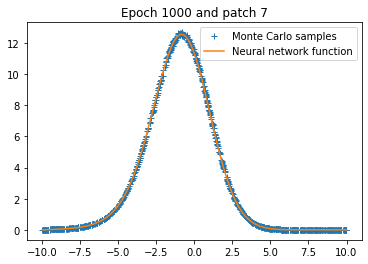

Patch 7: epoch 1000 with loss 0.0013515104074031115


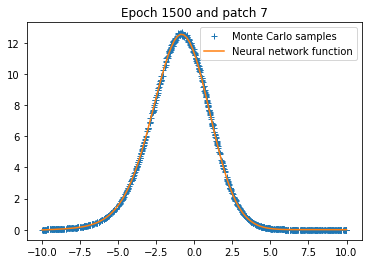

Patch 7: epoch 1500 with loss 0.0013404849451035261


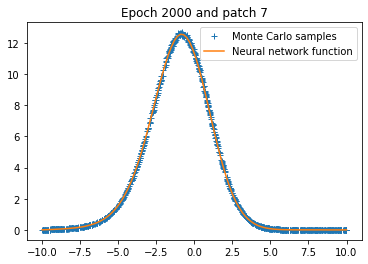

Patch 7: epoch 2000 with loss 0.0013545820256695151


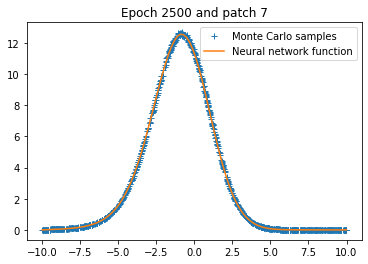

Patch 7: epoch 2500 with loss 0.0013355237897485495


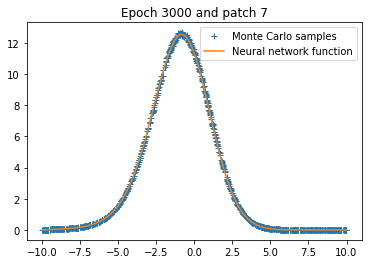

Patch 7: epoch 3000 with loss 0.0013345900224521756


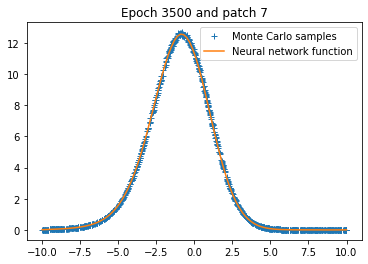

Patch 7: epoch 3500 with loss 0.0013286187313497066


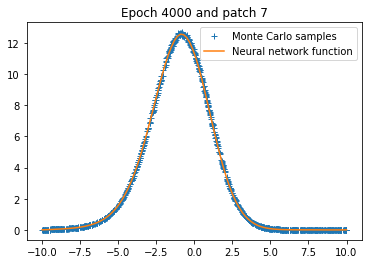

Patch 7: epoch 4000 with loss 0.0013283754233270884


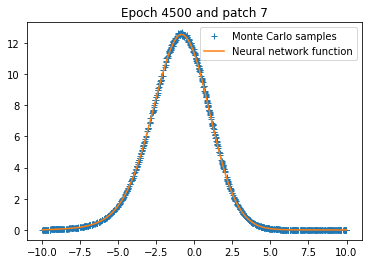

Patch 7: epoch 4500 with loss 0.0014055746141821146


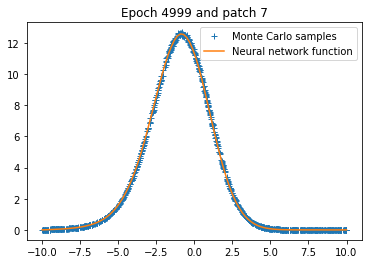

Patch 7: epoch 4999 with loss 0.0014617074048146605
Patch 7: training of neural network with 5000 epochs take 20.547606229782104 seconds.
Patch 8: generation of samples take 171.14643263816833 seconds.


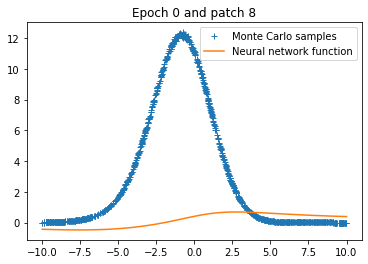

Patch 8: epoch 0 with loss 22.262861251831055


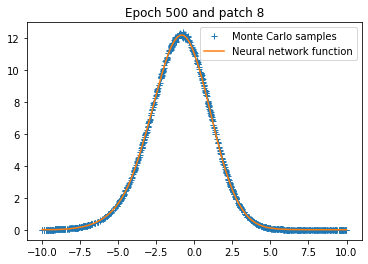

Patch 8: epoch 500 with loss 0.0013325945474207401


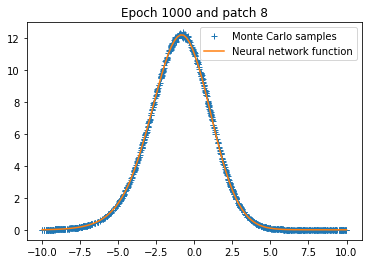

Patch 8: epoch 1000 with loss 0.0014479908859357238


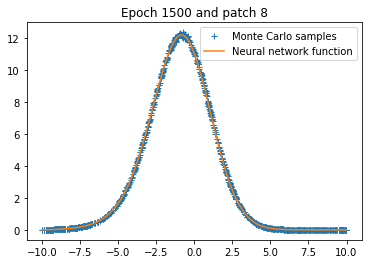

Patch 8: epoch 1500 with loss 0.0012669620336964726


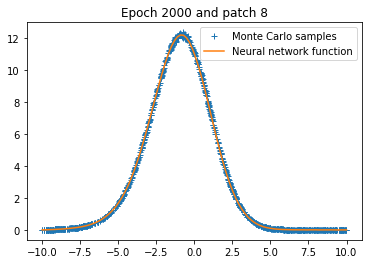

Patch 8: epoch 2000 with loss 0.0012635770253837109


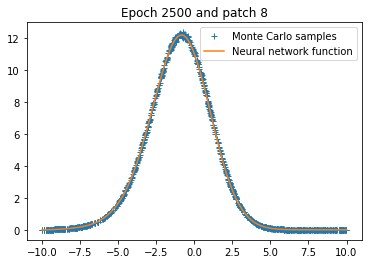

Patch 8: epoch 2500 with loss 0.0012593782739713788


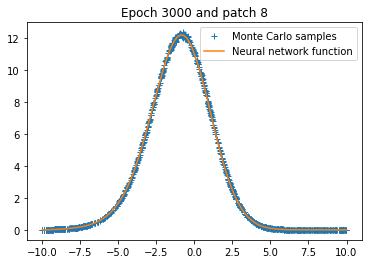

Patch 8: epoch 3000 with loss 0.0012608770048245788


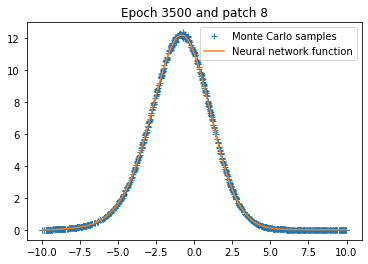

Patch 8: epoch 3500 with loss 0.0012528615770861506


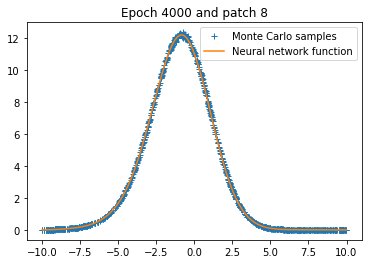

Patch 8: epoch 4000 with loss 0.0012571075931191444


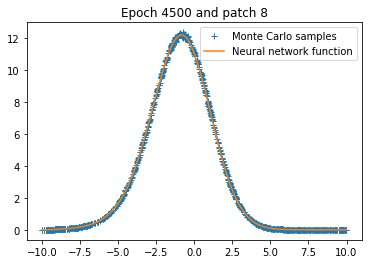

Patch 8: epoch 4500 with loss 0.0012539398157969117


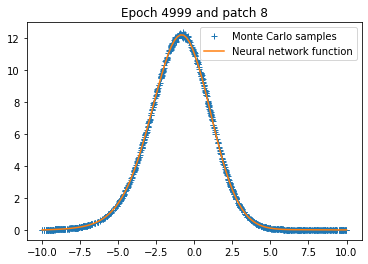

Patch 8: epoch 4999 with loss 0.0012620730558410287
Patch 8: training of neural network with 5000 epochs take 20.728371143341064 seconds.
Patch 9: generation of samples take 181.58661794662476 seconds.


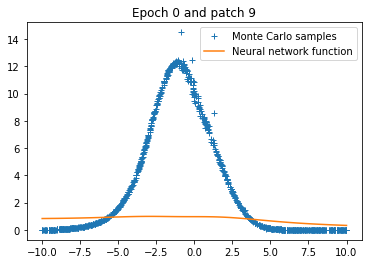

Patch 9: epoch 0 with loss 34.43661880493164


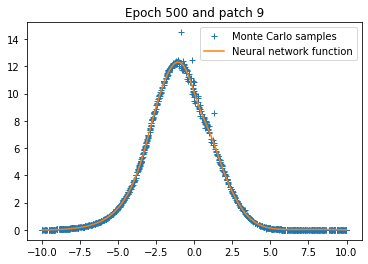

Patch 9: epoch 500 with loss 0.02066074125468731


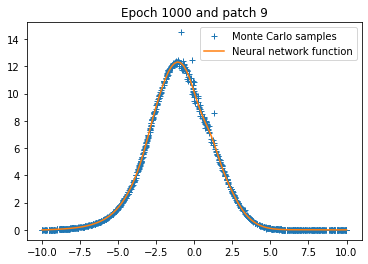

Patch 9: epoch 1000 with loss 0.020408378913998604


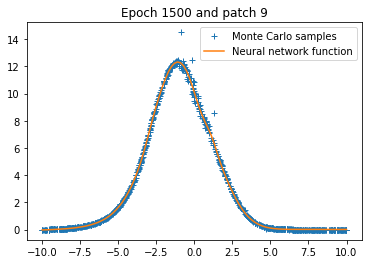

Patch 9: epoch 1500 with loss 0.020345164462924004


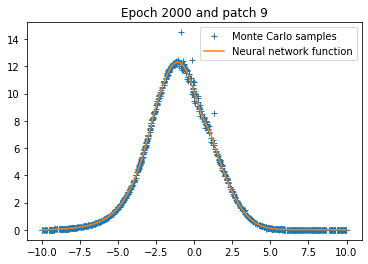

Patch 9: epoch 2000 with loss 0.02031698264181614


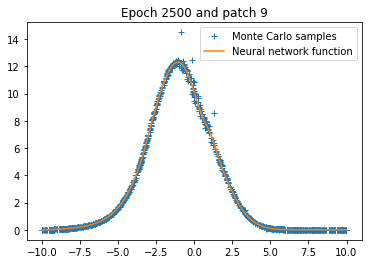

Patch 9: epoch 2500 with loss 0.020306367427110672


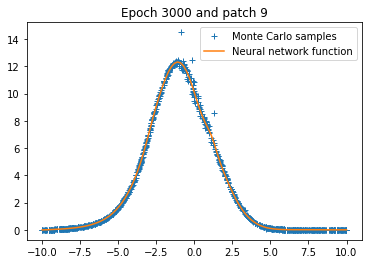

Patch 9: epoch 3000 with loss 0.020275888964533806


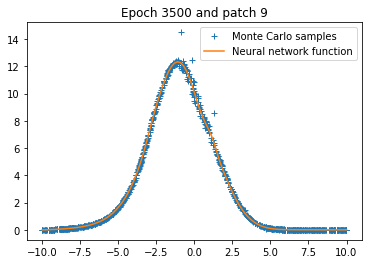

Patch 9: epoch 3500 with loss 0.020254112780094147


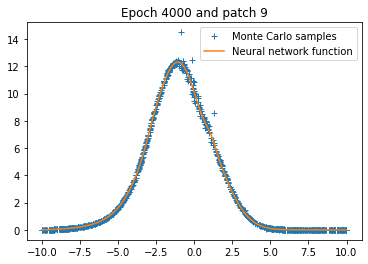

Patch 9: epoch 4000 with loss 0.02027156949043274


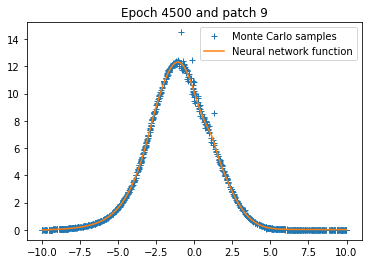

Patch 9: epoch 4500 with loss 0.02024245820939541


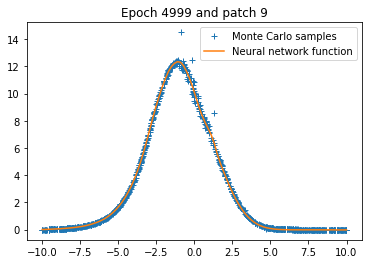

Patch 9: epoch 4999 with loss 0.02018774300813675
Patch 9: training of neural network with 5000 epochs take 21.138612270355225 seconds.


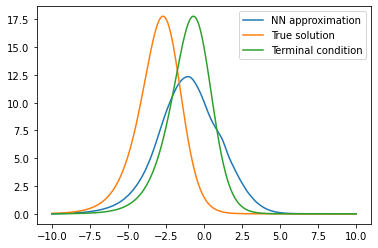

In [34]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=100,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.plot(grid, terminal, label="Terminal condition")
plt.legend()
plt.show()

### patches = 2, T = .2

In [31]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        15
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 2
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

Patch 0: generation of samples take 95.66228151321411 seconds.


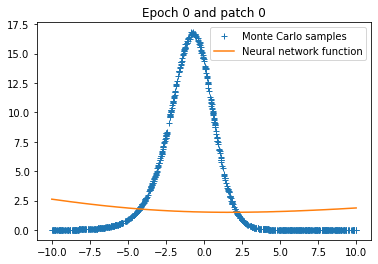

Patch 0: epoch 0 with loss 48.74153518676758


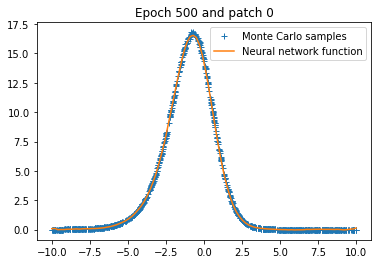

Patch 0: epoch 500 with loss 0.0020802037324756384


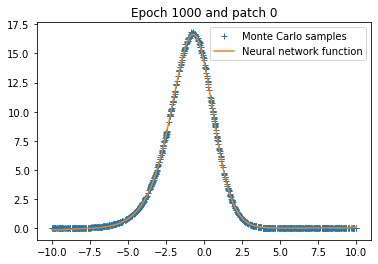

Patch 0: epoch 1000 with loss 0.004206632263958454


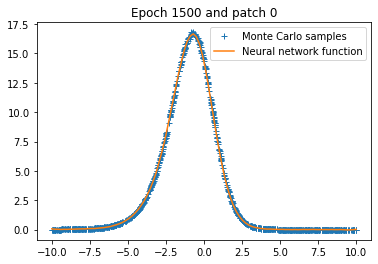

Patch 0: epoch 1500 with loss 0.001792317139916122


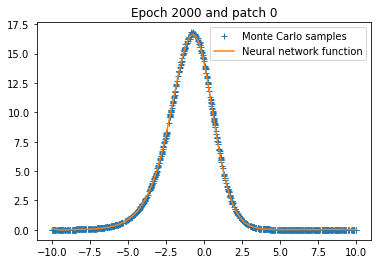

Patch 0: epoch 2000 with loss 0.0018033930100500584


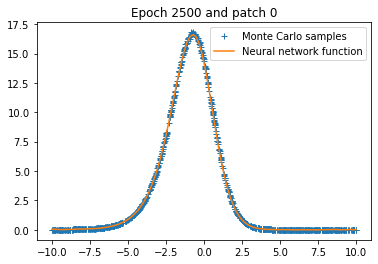

Patch 0: epoch 2500 with loss 0.0017917619552463293


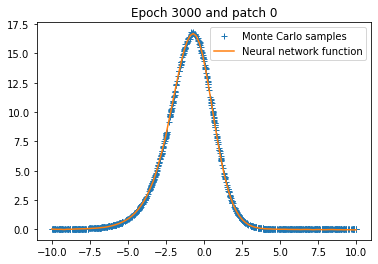

Patch 0: epoch 3000 with loss 0.0019235311774536967


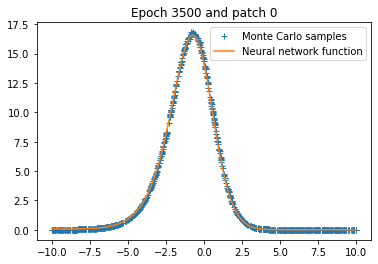

Patch 0: epoch 3500 with loss 0.0020270419772714376


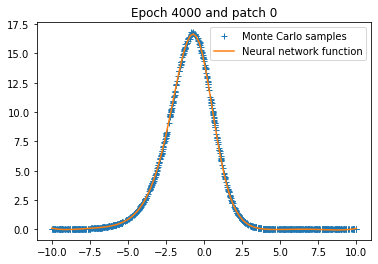

Patch 0: epoch 4000 with loss 0.0021678816992789507


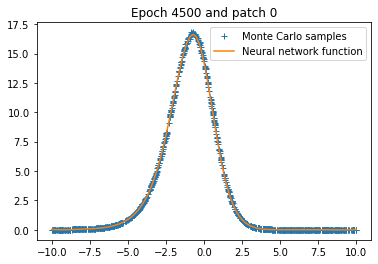

Patch 0: epoch 4500 with loss 0.0018264326499775052


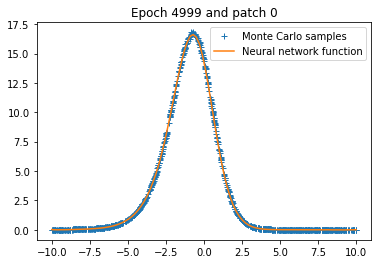

Patch 0: epoch 4999 with loss 0.0017819424392655492
Patch 0: training of neural network with 5000 epochs take 37.284075021743774 seconds.
Patch 1: generation of samples take 341.127888917923 seconds.


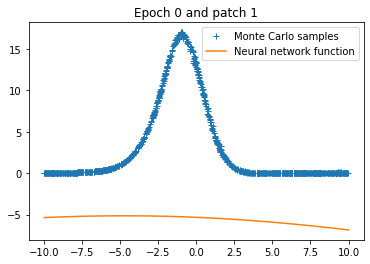

Patch 1: epoch 0 with loss 31.248048782348633


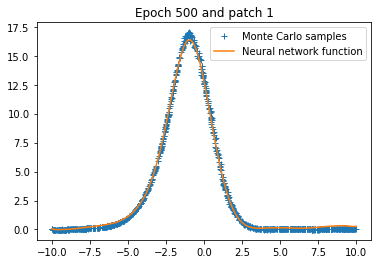

Patch 1: epoch 500 with loss 0.013338287360966206


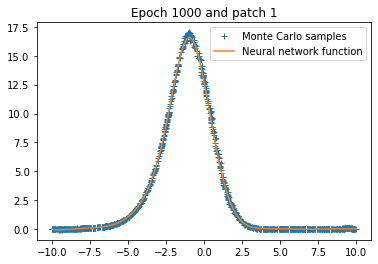

Patch 1: epoch 1000 with loss 0.00984883401542902


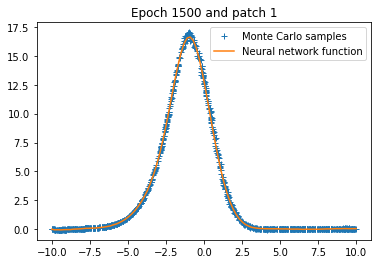

Patch 1: epoch 1500 with loss 0.009666222147643566


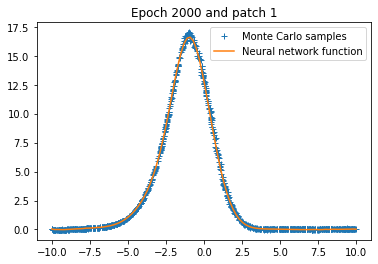

Patch 1: epoch 2000 with loss 0.009556879289448261


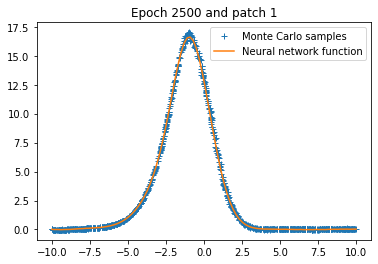

Patch 1: epoch 2500 with loss 0.009461627341806889


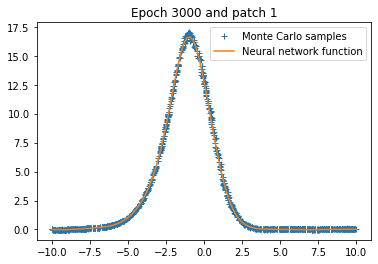

Patch 1: epoch 3000 with loss 0.00945217814296484


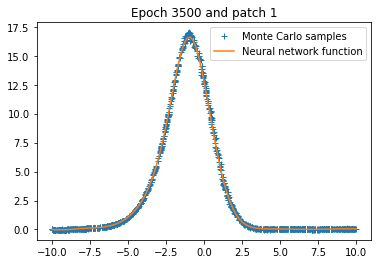

Patch 1: epoch 3500 with loss 0.009629704058170319


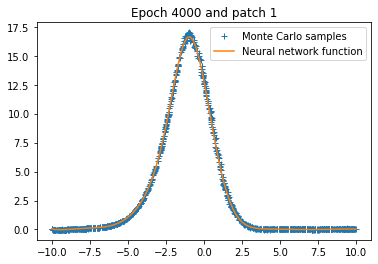

Patch 1: epoch 4000 with loss 0.009514139965176582


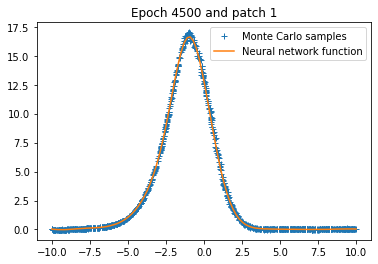

Patch 1: epoch 4500 with loss 0.009409081190824509


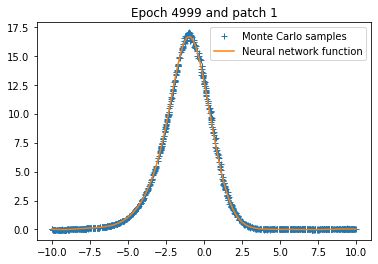

Patch 1: epoch 4999 with loss 0.00936761312186718
Patch 1: training of neural network with 5000 epochs take 37.71879553794861 seconds.


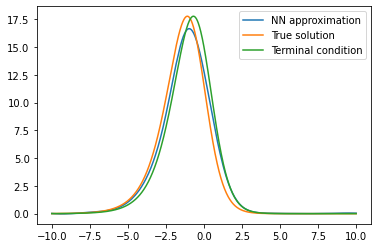

In [32]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=50,
    branch_activation="softplus",
    layers=6,
    neurons=50,
    branch_lr=1e-3,
    lr_gamma=.8,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.plot(grid, terminal, label="Terminal condition")
plt.legend()
plt.show()

### patches = 1, T = .1

In [24]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T, order=(0, 0)):
    theta = -.5 * x[0] - (T - t)
    if order[1] == 0:
        return (
            15
            + 15 * np.tanh(theta)
            - 15 * (np.tanh(theta))**2
            - 15 * (np.tanh(theta))**3
        )
    elif order[1] == 1:
        return -.5 / (np.cosh(theta))**2 * (
            15
            - 30 * np.tanh(theta)
            - 45 * (np.tanh(theta))**2
        )
    elif order[1] == 2:
        return (
            - .5 / (np.cosh(theta))**4 * (
                15 + 45 * np.tanh(theta)
            )
            - .5 * np.tanh(theta) / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 3:
        return (
            11.25 / (np.cosh(theta))**6
            + .25 / (np.cosh(theta))**4 * (
                15 - 120 * np.tanh(theta) - 315 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**2 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 4:
        return (
            1 / (np.cosh(theta))**6 * (
                15 + 112.5 * np.tanh(theta)
            )
            + .5 * np.tanh(theta) / (np.cosh(theta))**4 * (
                30 - 165 * np.tanh(theta) - 405 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**3 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 1
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

Patch 0: generation of samples take 90.56746649742126 seconds.


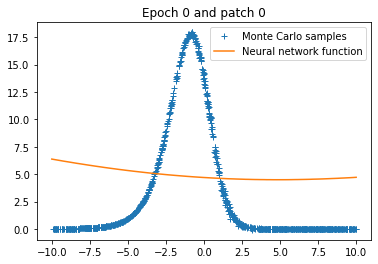

Patch 0: epoch 0 with loss 40.60592269897461


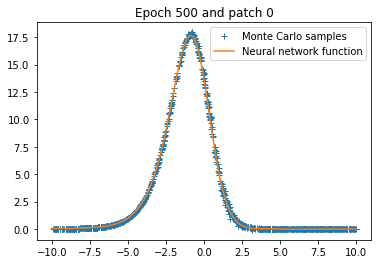

Patch 0: epoch 500 with loss 0.011413651518523693


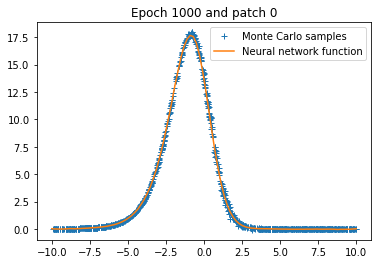

Patch 0: epoch 1000 with loss 0.01127629168331623


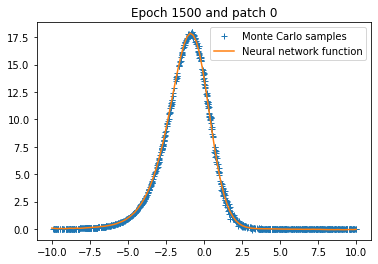

Patch 0: epoch 1500 with loss 0.011481910943984985


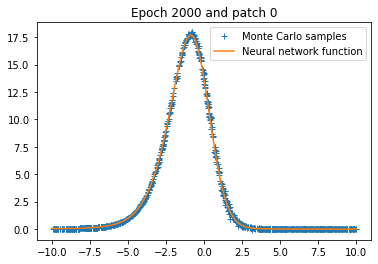

Patch 0: epoch 2000 with loss 0.0112138157710433


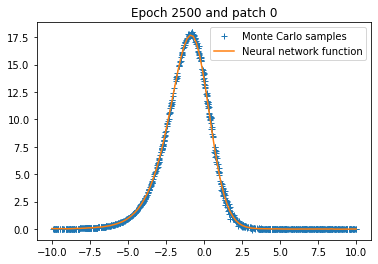

Patch 0: epoch 2500 with loss 0.011200854554772377


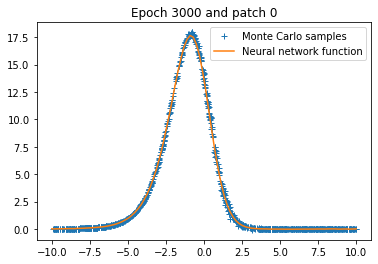

Patch 0: epoch 3000 with loss 0.01120759081095457


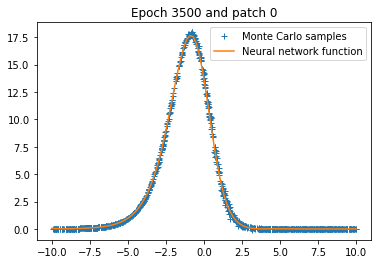

Patch 0: epoch 3500 with loss 0.011313549242913723


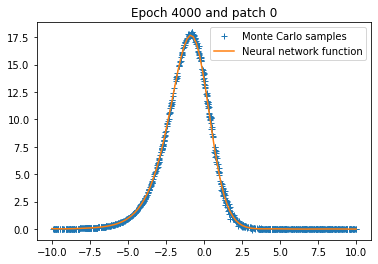

Patch 0: epoch 4000 with loss 0.011242985725402832


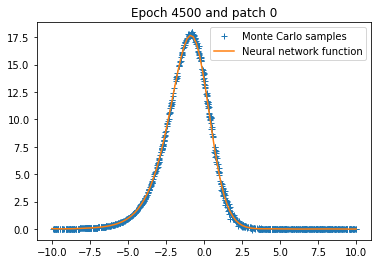

Patch 0: epoch 4500 with loss 0.011209551244974136


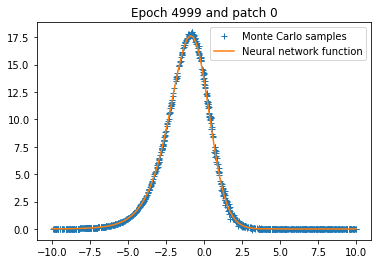

Patch 0: epoch 4999 with loss 0.011177754029631615
Patch 0: training of neural network with 5000 epochs take 36.678444385528564 seconds.


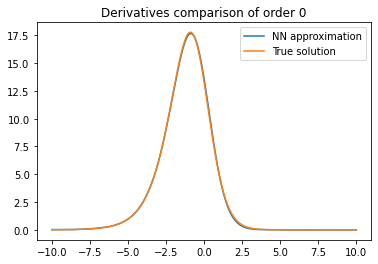

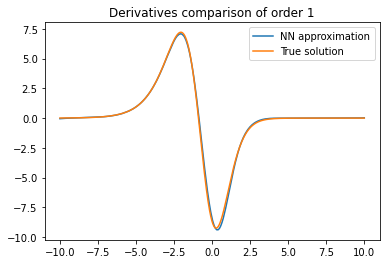

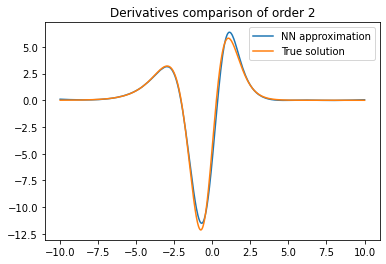

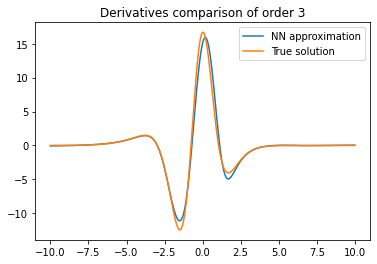

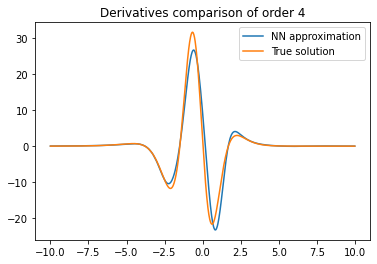

In [28]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=50,
    branch_activation="softplus",
    layers=6,
    neurons=50,
    branch_lr=1e-3,
    lr_gamma=.8,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
for order in ((0, 0), (0, 1), (0, 2), (0, 3), (0, 4)):
    true = exact_example(t_lo, grid_d_dim, T, order=order)
    x = torch.tensor(grid_d_dim_with_t.astype(np.float32), device=model.device, requires_grad=True)
    y =  model(x.T, patch=patches-1)
    deriv = model.nth_derivatives(order, y, x)
    plt.plot(grid, deriv.detach().cpu(), label="NN approximation")
    plt.plot(grid, true, label="True solution")
    plt.title(f"Derivatives comparison of order {order[1]}")
    plt.legend()
    plt.show()

## Example 3: Kuramoto equation 5

In [18]:
alpha, gamma = 1, 1

# function definition
deriv_map = np.array([0, 1, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> forth deriv
    """
    return y[0] * y[1] + gamma * y[2]

def phi_example(x):
    return torch.exp(-x[0]**2)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

patches = 10
T = patches * .1

Patch 0: generation of samples take 1.610029697418213 seconds.


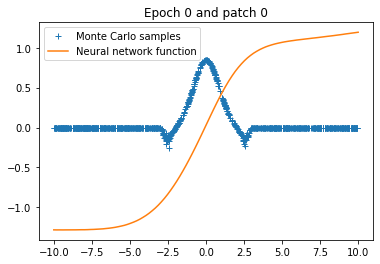

Patch 0: epoch 0 with loss 7.349950313568115


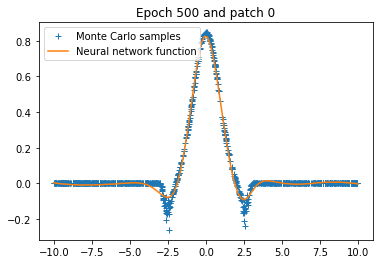

Patch 0: epoch 500 with loss 0.00036450420157052577


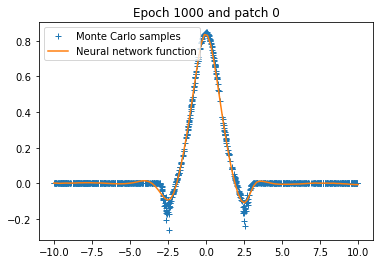

Patch 0: epoch 1000 with loss 0.00022802954481448978


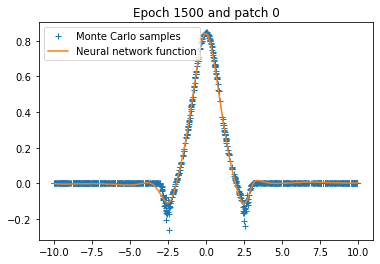

Patch 0: epoch 1500 with loss 0.00018370244652032852


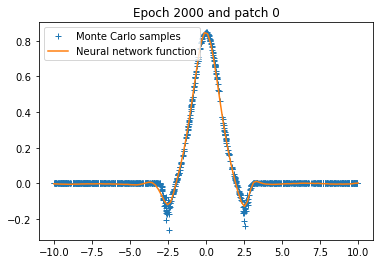

Patch 0: epoch 2000 with loss 0.00013006976223550737


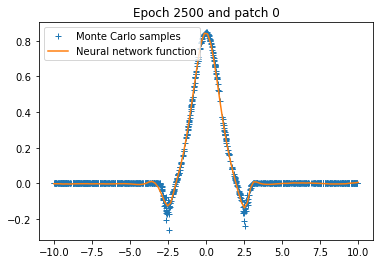

Patch 0: epoch 2500 with loss 0.000103889120509848


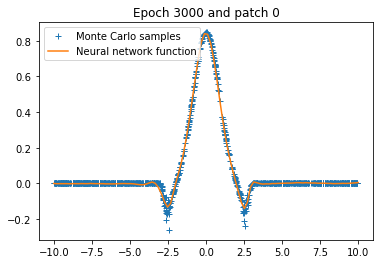

Patch 0: epoch 3000 with loss 9.239924111170694e-05


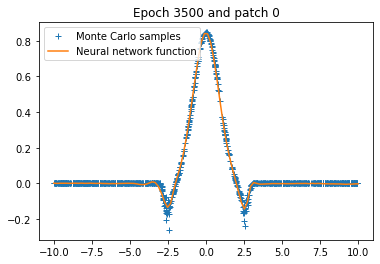

Patch 0: epoch 3500 with loss 9.069544466910884e-05


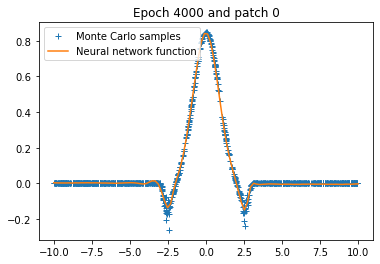

Patch 0: epoch 4000 with loss 9.909521759254858e-05


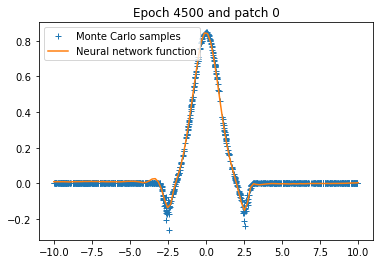

Patch 0: epoch 4500 with loss 0.0001243408041773364


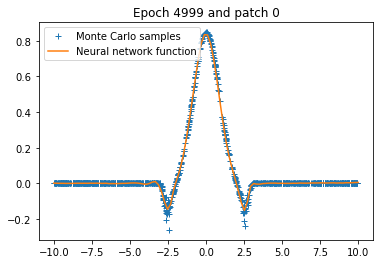

Patch 0: epoch 4999 with loss 8.467439329251647e-05
Patch 0: training of neural network with 5000 epochs take 26.171342849731445 seconds.
Patch 1: generation of samples take 5.691176652908325 seconds.


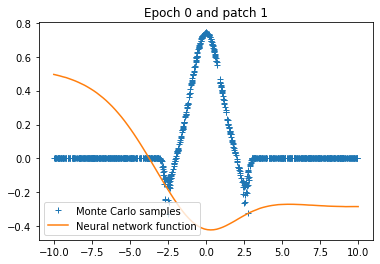

Patch 1: epoch 0 with loss 5.079821586608887


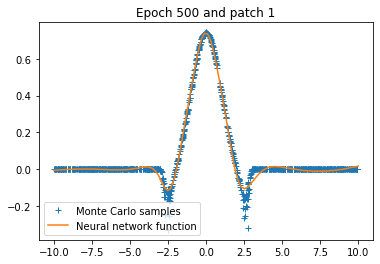

Patch 1: epoch 500 with loss 0.0005201384774409235


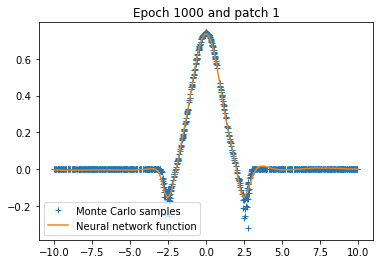

Patch 1: epoch 1000 with loss 0.0002791092556435615


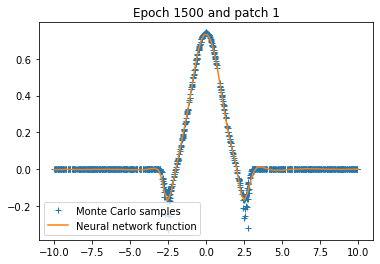

Patch 1: epoch 1500 with loss 0.0002019222010858357


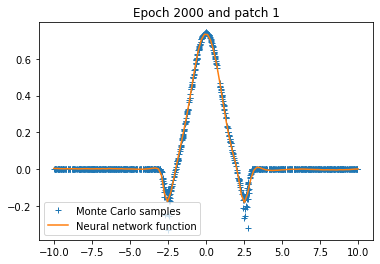

Patch 1: epoch 2000 with loss 0.000182955976924859


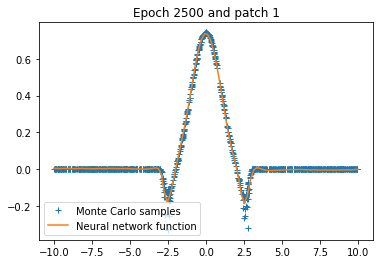

Patch 1: epoch 2500 with loss 0.00016957875050138682


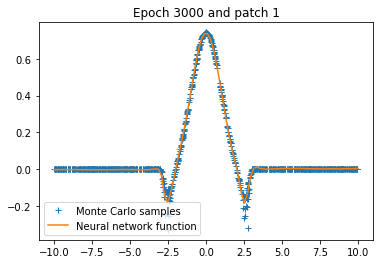

Patch 1: epoch 3000 with loss 0.00016568208229728043


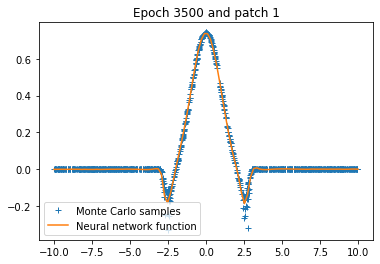

Patch 1: epoch 3500 with loss 0.0001605687284609303


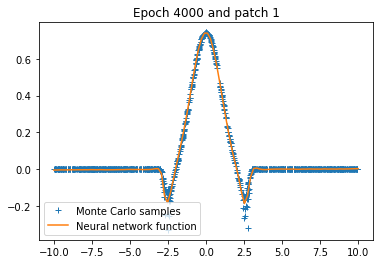

Patch 1: epoch 4000 with loss 0.0001663719303905964


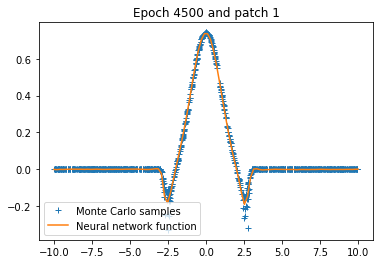

Patch 1: epoch 4500 with loss 0.00016293168300762773


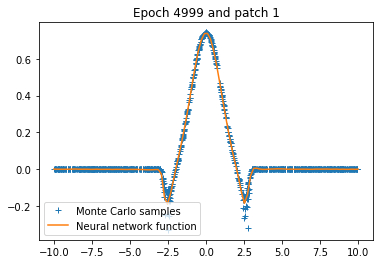

Patch 1: epoch 4999 with loss 0.00015624154184479266
Patch 1: training of neural network with 5000 epochs take 24.0492160320282 seconds.
Patch 2: generation of samples take 4.978959798812866 seconds.


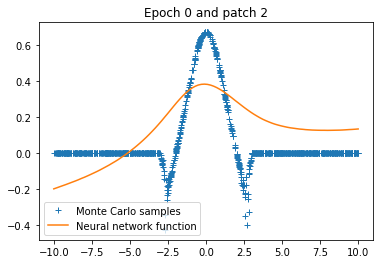

Patch 2: epoch 0 with loss 1.7434691190719604


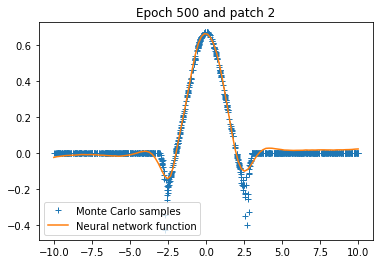

Patch 2: epoch 500 with loss 0.0007234927616082132


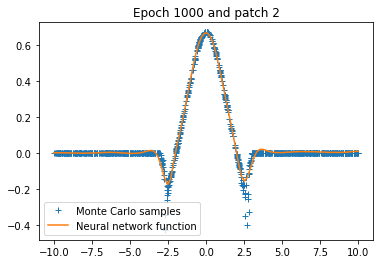

Patch 2: epoch 1000 with loss 0.0004178874660283327


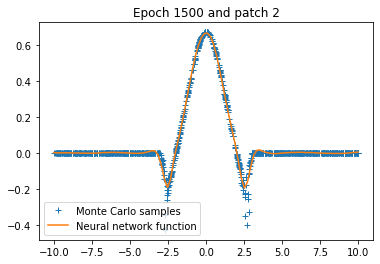

Patch 2: epoch 1500 with loss 0.00031856884015724063


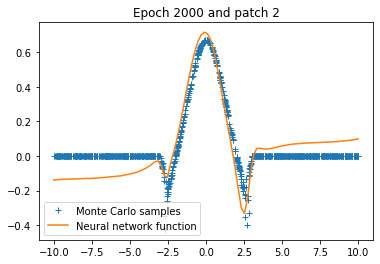

Patch 2: epoch 2000 with loss 0.0034681952092796564


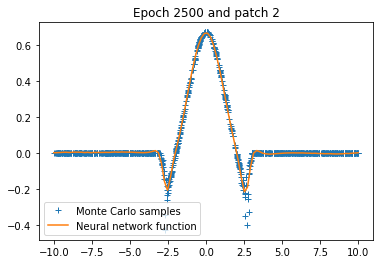

Patch 2: epoch 2500 with loss 0.00025351456133648753


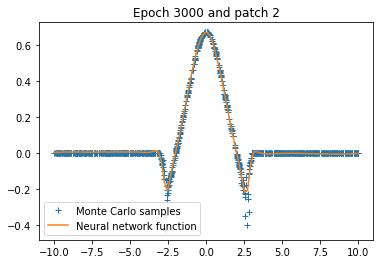

Patch 2: epoch 3000 with loss 0.000225996263907291


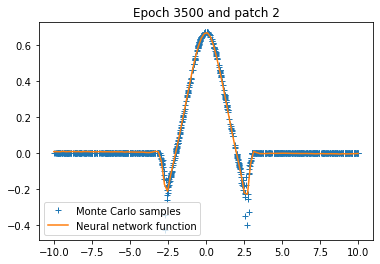

Patch 2: epoch 3500 with loss 0.00021375325741246343


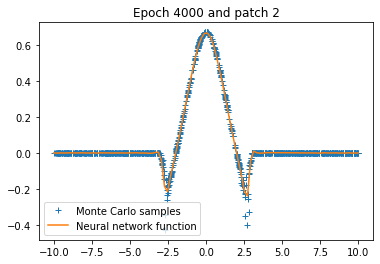

Patch 2: epoch 4000 with loss 0.00018661655485630035


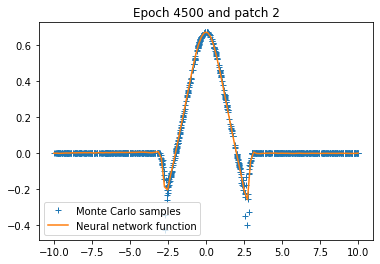

Patch 2: epoch 4500 with loss 0.00017734857101459056


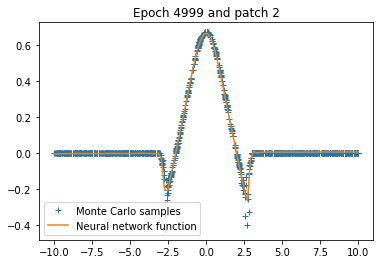

Patch 2: epoch 4999 with loss 0.00017688462685327977
Patch 2: training of neural network with 5000 epochs take 30.118369817733765 seconds.
Patch 3: generation of samples take 6.474772930145264 seconds.


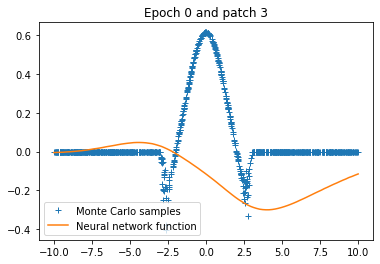

Patch 3: epoch 0 with loss 4.679110527038574


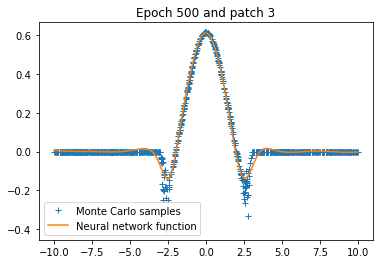

Patch 3: epoch 500 with loss 0.0004708255873993039


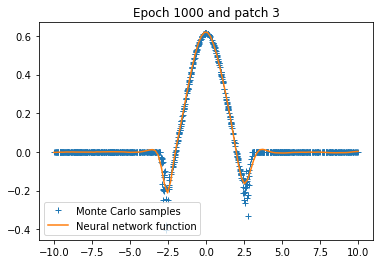

Patch 3: epoch 1000 with loss 0.0002892426564358175


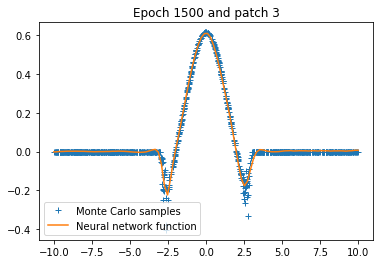

Patch 3: epoch 1500 with loss 0.00023223049356602132


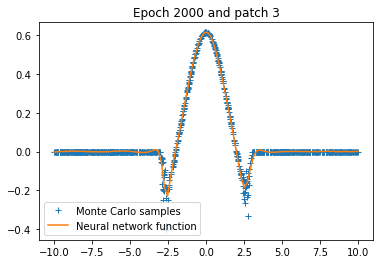

Patch 3: epoch 2000 with loss 0.00021279940847307444


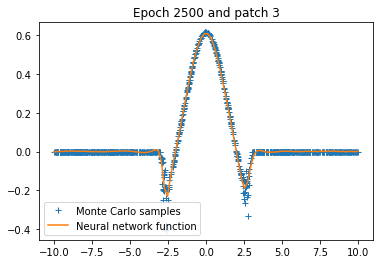

Patch 3: epoch 2500 with loss 0.00020425037655513734


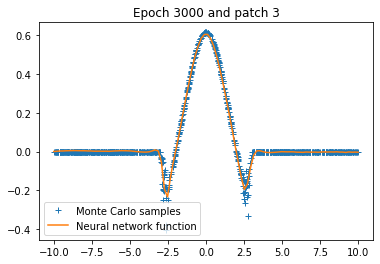

Patch 3: epoch 3000 with loss 0.0002277293970109895


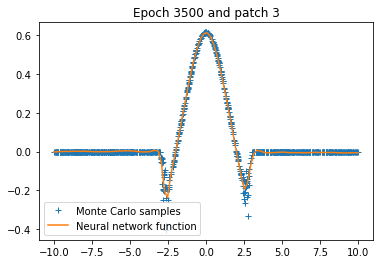

Patch 3: epoch 3500 with loss 0.00019734616216737777


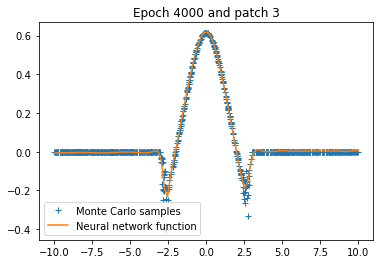

Patch 3: epoch 4000 with loss 0.0002010299067478627


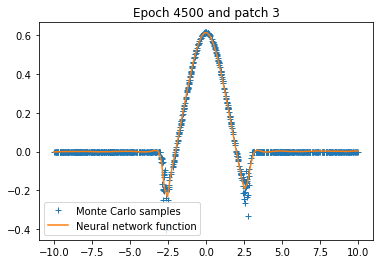

Patch 3: epoch 4500 with loss 0.0001944922551047057


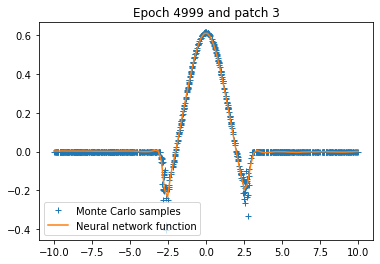

Patch 3: epoch 4999 with loss 0.00020191926159895957
Patch 3: training of neural network with 5000 epochs take 21.264551162719727 seconds.
Patch 4: generation of samples take 3.852834701538086 seconds.


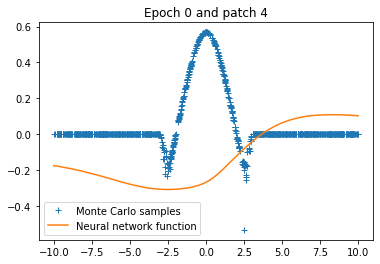

Patch 4: epoch 0 with loss 0.3831512928009033


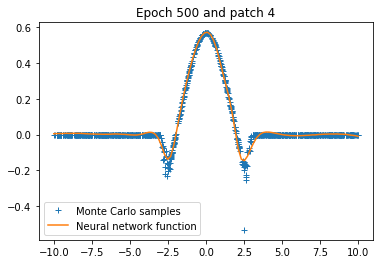

Patch 4: epoch 500 with loss 0.0003440397558733821


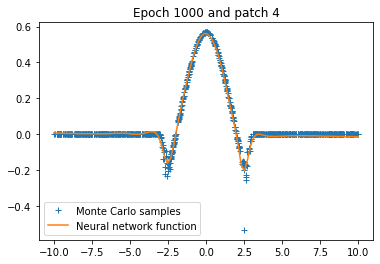

Patch 4: epoch 1000 with loss 0.0002316530590178445


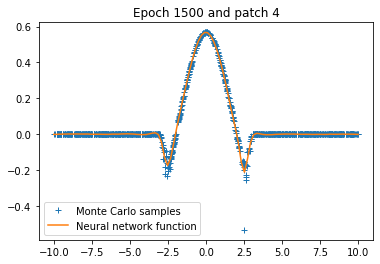

Patch 4: epoch 1500 with loss 0.000174462707946077


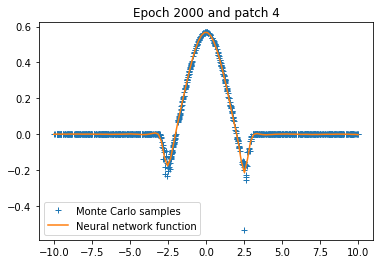

Patch 4: epoch 2000 with loss 0.0001730328513076529


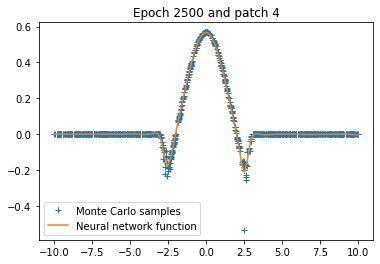

Patch 4: epoch 2500 with loss 0.00017250840028282255


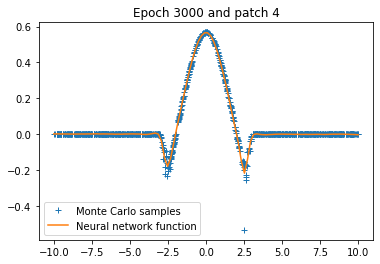

Patch 4: epoch 3000 with loss 0.0001705583999864757


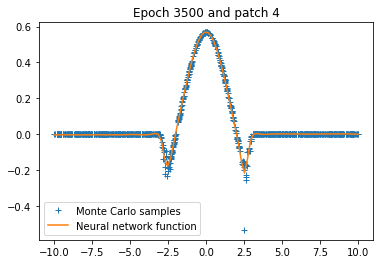

Patch 4: epoch 3500 with loss 0.00017377307813148946


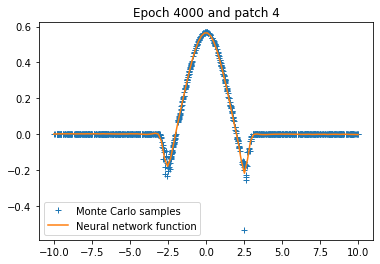

Patch 4: epoch 4000 with loss 0.0001721115258987993


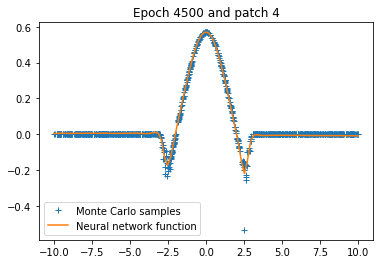

Patch 4: epoch 4500 with loss 0.00018797161465045065


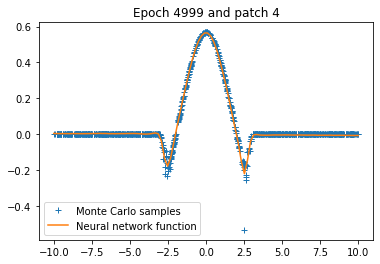

Patch 4: epoch 4999 with loss 0.00017100606055464596
Patch 4: training of neural network with 5000 epochs take 20.150026559829712 seconds.
Patch 5: generation of samples take 4.040656089782715 seconds.


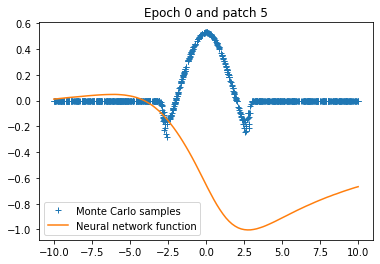

Patch 5: epoch 0 with loss 0.3283827006816864


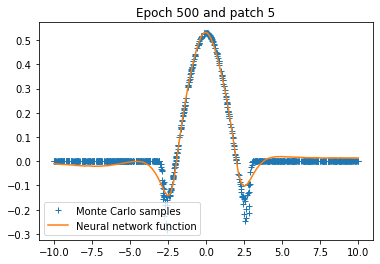

Patch 5: epoch 500 with loss 0.00038930209120735526


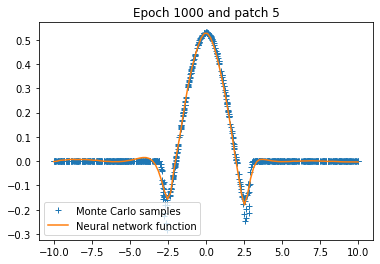

Patch 5: epoch 1000 with loss 0.00016813786351121962


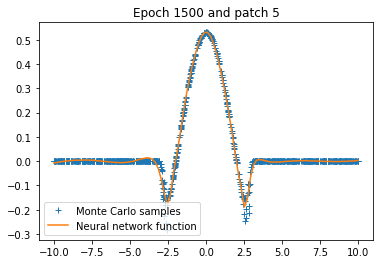

Patch 5: epoch 1500 with loss 0.00013027981913182884


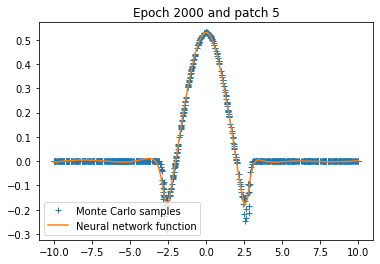

Patch 5: epoch 2000 with loss 0.00011983231524936855


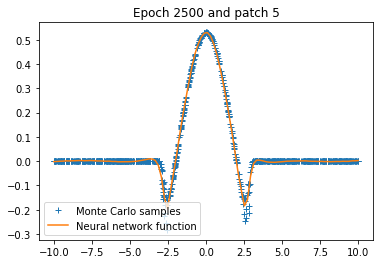

Patch 5: epoch 2500 with loss 9.279030928155407e-05


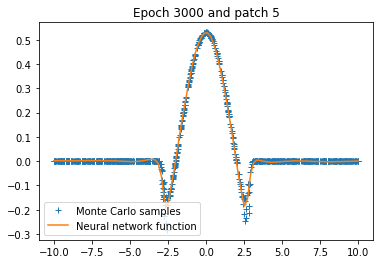

Patch 5: epoch 3000 with loss 8.412534225499257e-05


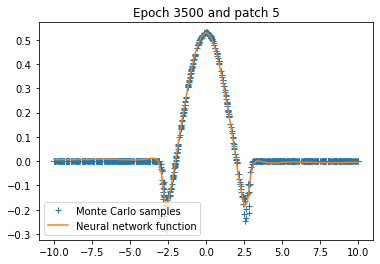

Patch 5: epoch 3500 with loss 0.00011344020458636805


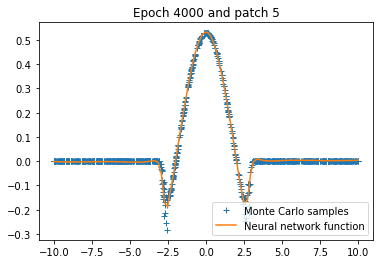

Patch 5: epoch 4000 with loss 8.276404696516693e-05


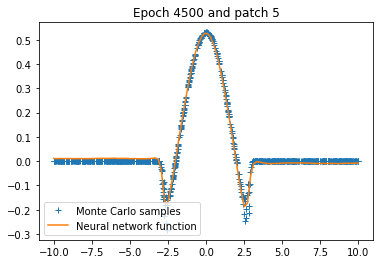

Patch 5: epoch 4500 with loss 0.0001265838072868064


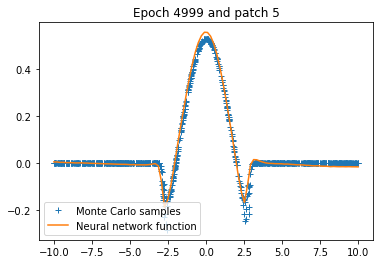

Patch 5: epoch 4999 with loss 0.00014203156752046198
Patch 5: training of neural network with 5000 epochs take 24.51444697380066 seconds.
Patch 6: generation of samples take 6.714064121246338 seconds.


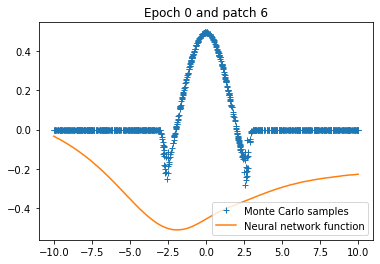

Patch 6: epoch 0 with loss 1.5342000722885132


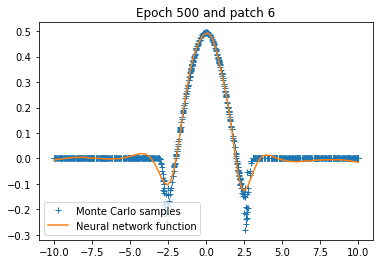

Patch 6: epoch 500 with loss 0.00038490621955133975


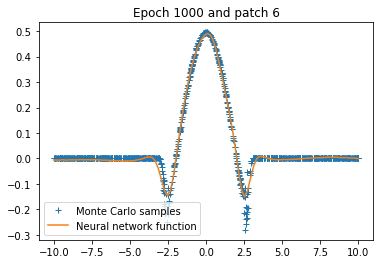

Patch 6: epoch 1000 with loss 0.0002151739754481241


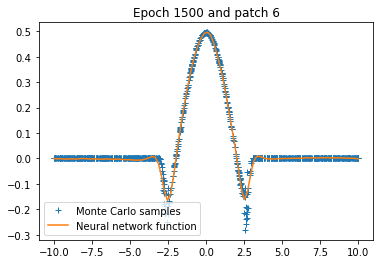

Patch 6: epoch 1500 with loss 0.00015755323693156242


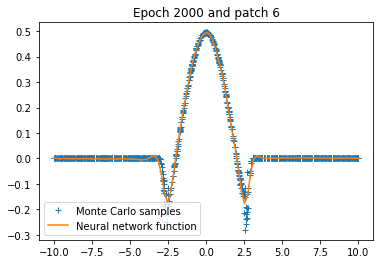

Patch 6: epoch 2000 with loss 0.00013189487799536437


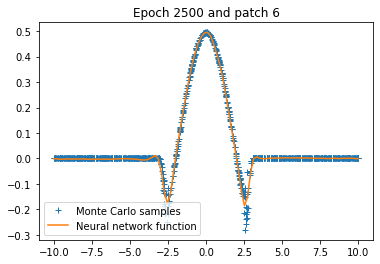

Patch 6: epoch 2500 with loss 0.00011048202577512711


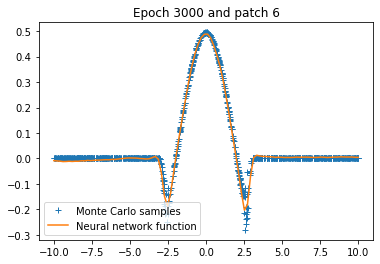

Patch 6: epoch 3000 with loss 0.00017101524281315506


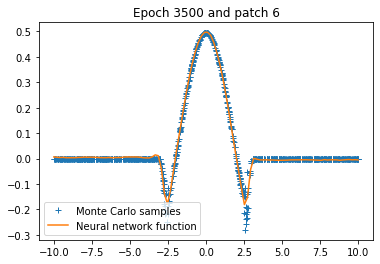

Patch 6: epoch 3500 with loss 9.506590868113562e-05


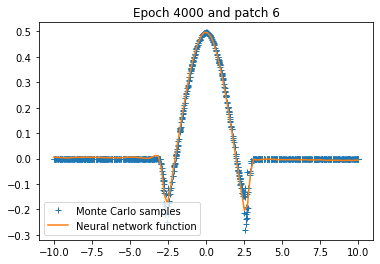

Patch 6: epoch 4000 with loss 0.00011904558778041974


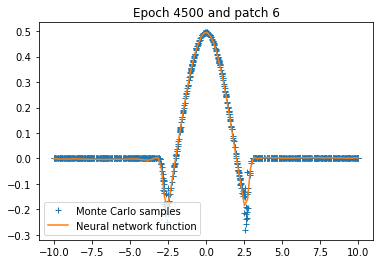

Patch 6: epoch 4500 with loss 8.55380785651505e-05


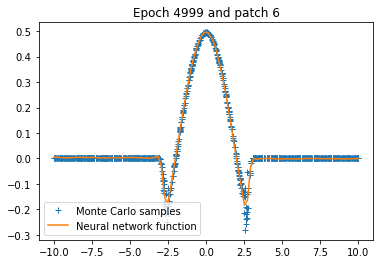

Patch 6: epoch 4999 with loss 8.47533083287999e-05
Patch 6: training of neural network with 5000 epochs take 23.07128119468689 seconds.
Patch 7: generation of samples take 4.9373979568481445 seconds.


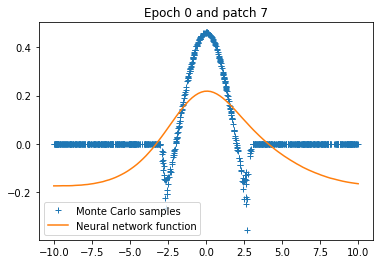

Patch 7: epoch 0 with loss 5.946298122406006


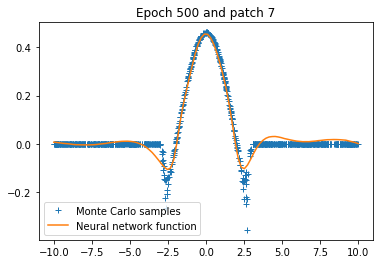

Patch 7: epoch 500 with loss 0.0005186536000110209


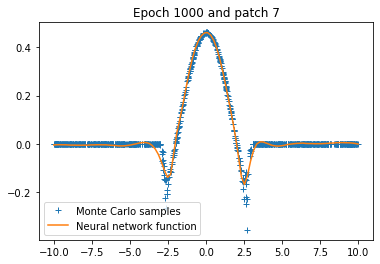

Patch 7: epoch 1000 with loss 0.00020029024744872004


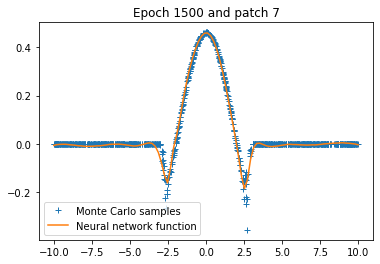

Patch 7: epoch 1500 with loss 0.00014386327529791743


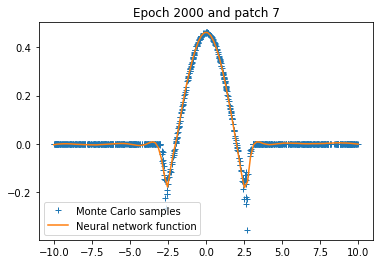

Patch 7: epoch 2000 with loss 0.00011463182454463094


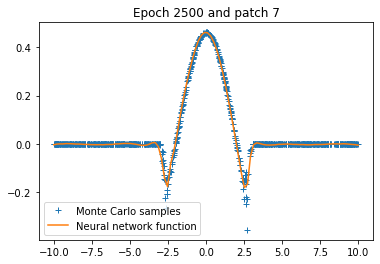

Patch 7: epoch 2500 with loss 0.00011157160042785108


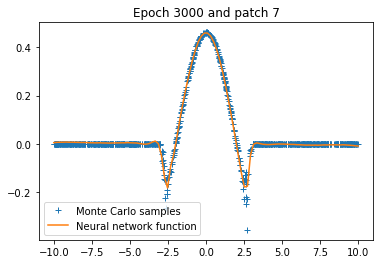

Patch 7: epoch 3000 with loss 0.00012754593626596034


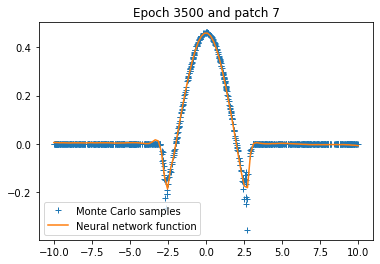

Patch 7: epoch 3500 with loss 9.814396617002785e-05


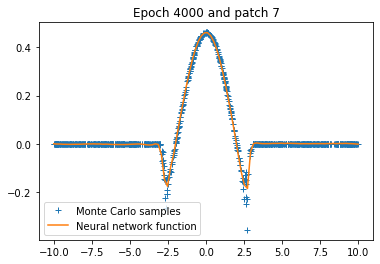

Patch 7: epoch 4000 with loss 8.60650761751458e-05


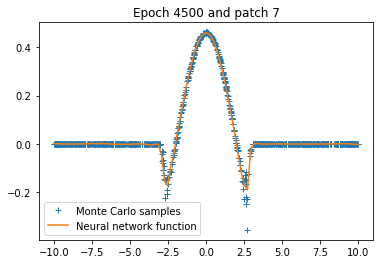

Patch 7: epoch 4500 with loss 8.227462240029126e-05


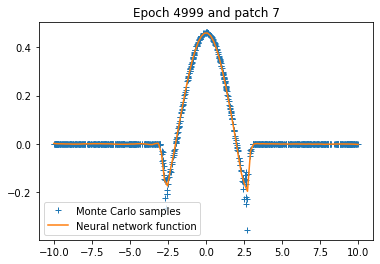

Patch 7: epoch 4999 with loss 7.860679761506617e-05
Patch 7: training of neural network with 5000 epochs take 24.89271354675293 seconds.
Patch 8: generation of samples take 4.371016025543213 seconds.


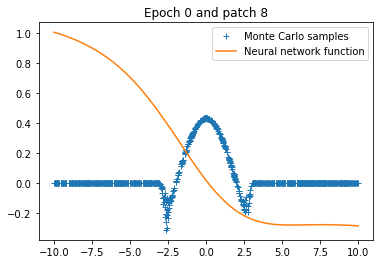

Patch 8: epoch 0 with loss 1.3640788793563843


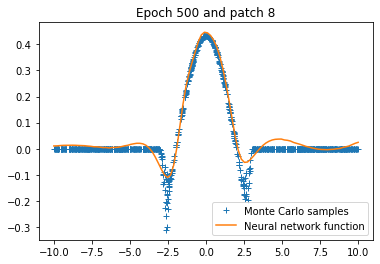

Patch 8: epoch 500 with loss 0.0005557386903092265


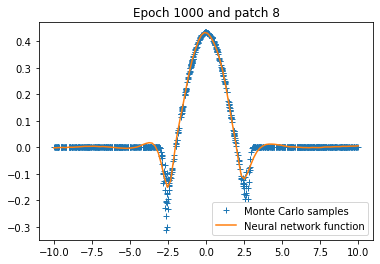

Patch 8: epoch 1000 with loss 0.0002244167117169127


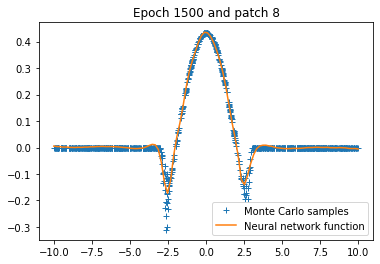

Patch 8: epoch 1500 with loss 0.00015439995331689715


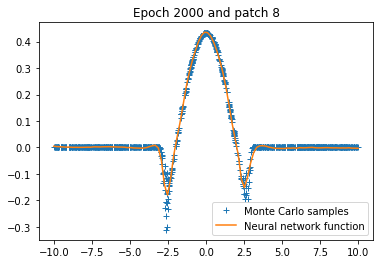

Patch 8: epoch 2000 with loss 0.00013289392518345267


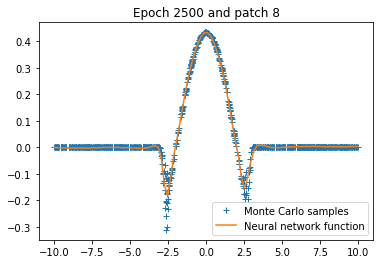

Patch 8: epoch 2500 with loss 0.0001225809392053634


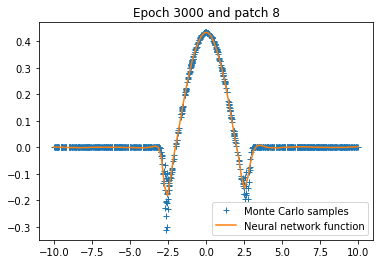

Patch 8: epoch 3000 with loss 0.00011528311006259173


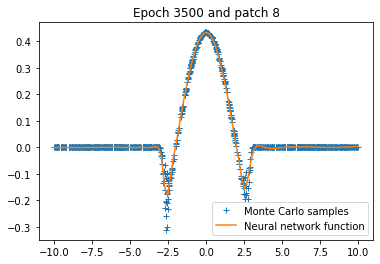

Patch 8: epoch 3500 with loss 0.00011093130888184533


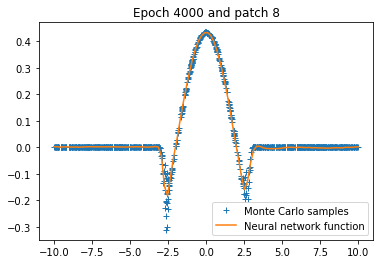

Patch 8: epoch 4000 with loss 0.0001126189308706671


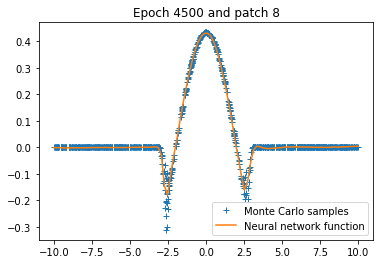

Patch 8: epoch 4500 with loss 0.00011218202416785061


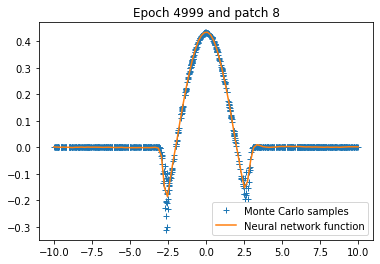

Patch 8: epoch 4999 with loss 0.00011005646956618875
Patch 8: training of neural network with 5000 epochs take 25.068533420562744 seconds.
Patch 9: generation of samples take 6.2217254638671875 seconds.


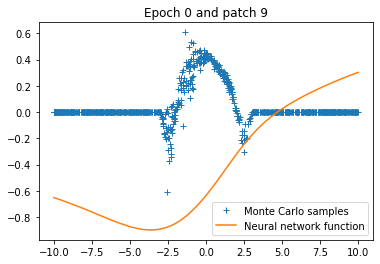

Patch 9: epoch 0 with loss 0.48417776823043823


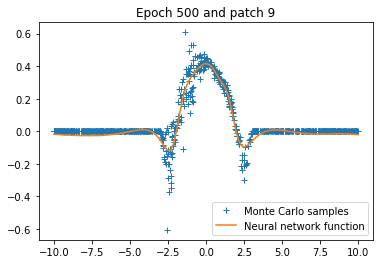

Patch 9: epoch 500 with loss 0.0018154472345486283


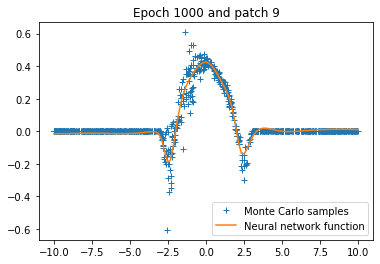

Patch 9: epoch 1000 with loss 0.0014558375114575028


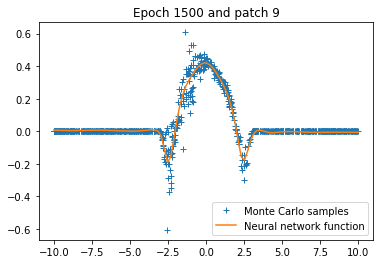

Patch 9: epoch 1500 with loss 0.0014077003579586744


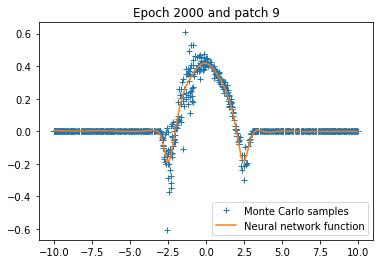

Patch 9: epoch 2000 with loss 0.0013953264569863677


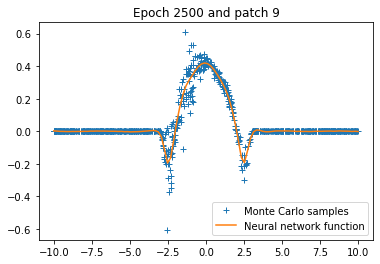

Patch 9: epoch 2500 with loss 0.0013869235990568995


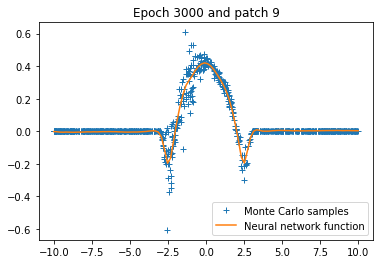

Patch 9: epoch 3000 with loss 0.0013861212646588683


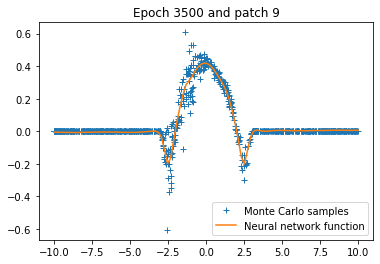

Patch 9: epoch 3500 with loss 0.001378600369207561


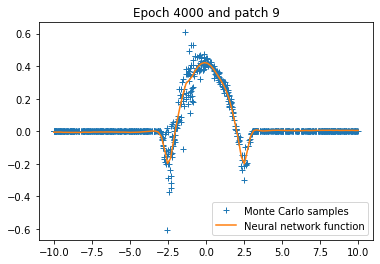

Patch 9: epoch 4000 with loss 0.0013781740562990308


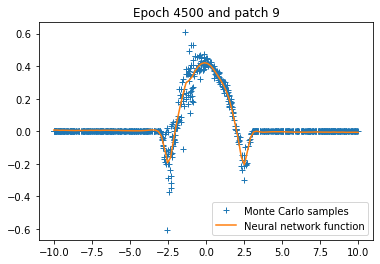

Patch 9: epoch 4500 with loss 0.0013745754258707166


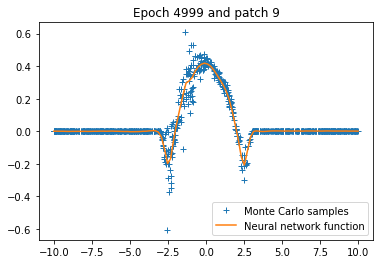

Patch 9: epoch 4999 with loss 0.0013702953001484275
Patch 9: training of neural network with 5000 epochs take 21.490774869918823 seconds.


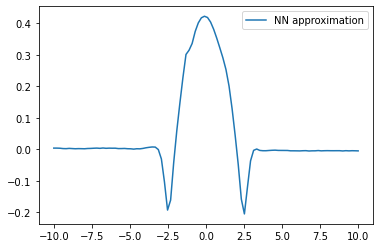

In [17]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.legend()
plt.show()

# Implementation with DGM

We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{cases}
$$

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [5]:
y, eps = 1, 2e-1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return 1 - np.exp(((y - x[0])**2 - (4 - x[0] - y)**2)/(2 * (T - t)))

t_lo, x_lo, x_hi, n = 0., -1., 2., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

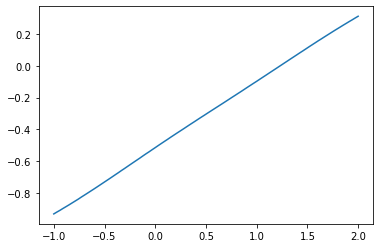

Epoch 0 with loss 4.368678569793701


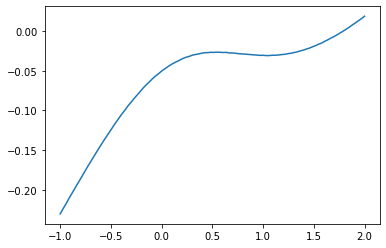

Epoch 500 with loss 0.11923092603683472


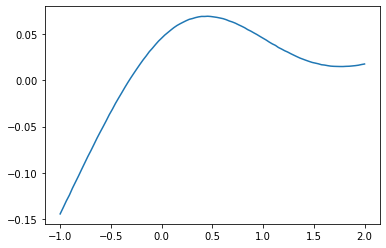

Epoch 1000 with loss 0.1096392348408699


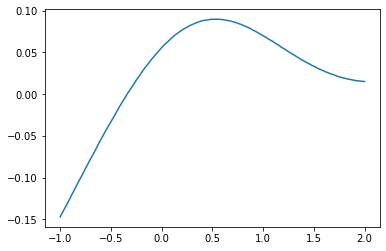

Epoch 1500 with loss 0.10495362430810928


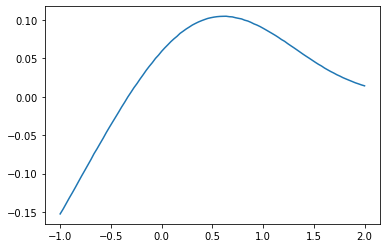

Epoch 2000 with loss 0.10371804982423782


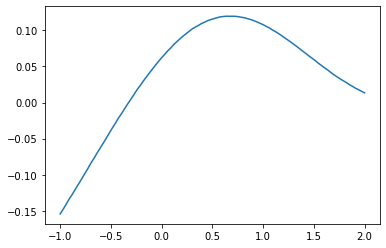

Epoch 2500 with loss 0.10179402679204941


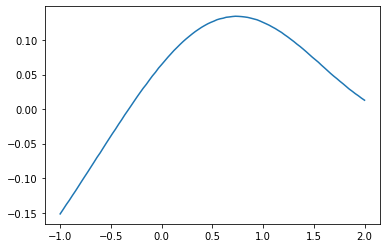

Epoch 3000 with loss 0.09844131022691727


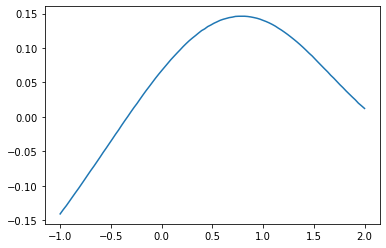

Epoch 3500 with loss 0.09383401274681091


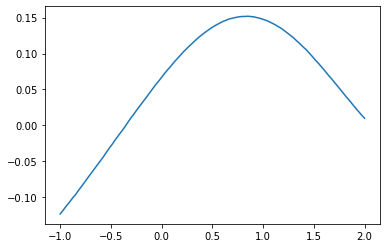

Epoch 4000 with loss 0.09355247765779495


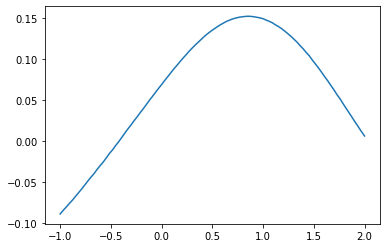

Epoch 4500 with loss 0.09043486416339874


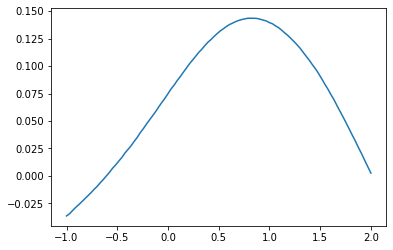

Epoch 5000 with loss 0.08446547389030457


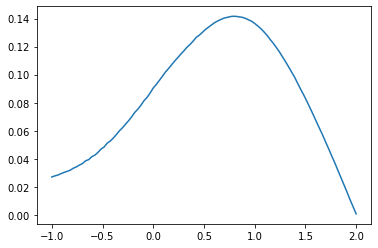

Epoch 5500 with loss 0.07782397419214249


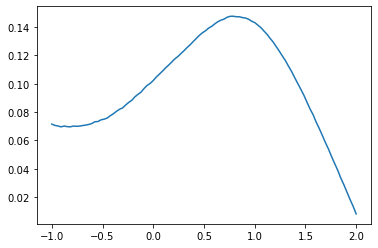

Epoch 6000 with loss 0.07417459040880203


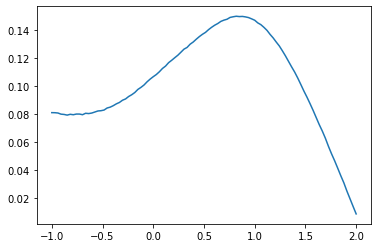

Epoch 6500 with loss 0.07086066156625748


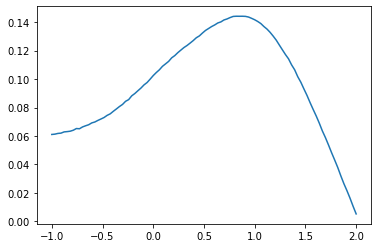

Epoch 7000 with loss 0.06356269121170044


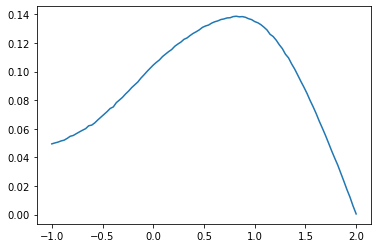

Epoch 7500 with loss 0.056263282895088196


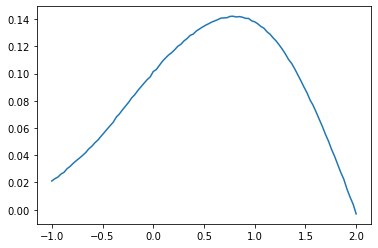

Epoch 8000 with loss 0.05006927251815796


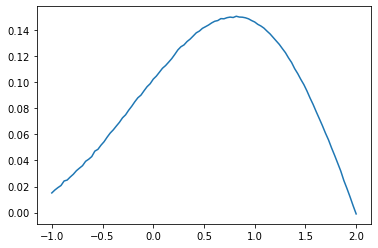

Epoch 8500 with loss 0.03991055488586426


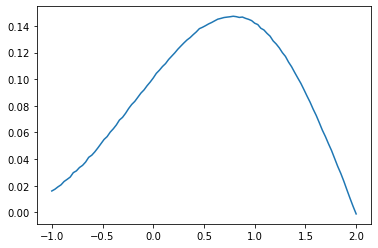

Epoch 9000 with loss 0.03220843896269798


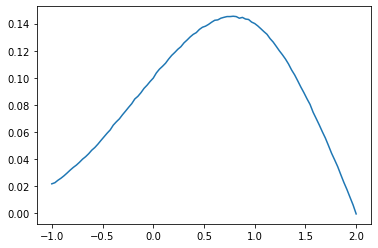

Epoch 9500 with loss 0.02545122057199478


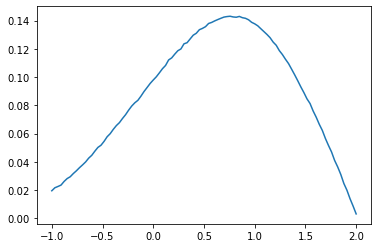

Epoch 9999 with loss 0.022177185863256454
Training of neural network with 10000 epochs take 148.87680578231812 seconds.


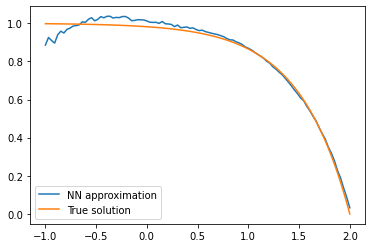

In [6]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
    overtrain_rate=0.,
    verbose=True,
    lambda_terminal=1.,
    lambda_boundary=10.,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
nn /= (norm.cdf(b - grid) - norm.cdf(a - grid))
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.legend()
plt.show()

In [7]:
tx, tx_term, tx_bound = model.gen_sample()

print(
    f"Terminal loss: {model.loss(model(tx_term.T), model.phi_fun(tx_term[1:, :])).item()}"
)
print(
    f"PDE loss: {model.pde_loss(tx)}"
)
print(
    f"Boundary loss: {model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1]))}"
)

Terminal loss: 0.019741717725992203
PDE loss: 0.0034045714419335127
Boundary loss: 1.012984193948796e-05
